In [1]:
pip install datasets


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install modelscope

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [4]:
!modelscope download --dataset swift/Chinese-Qwen3-235B-Thinking-2507-Distill-data-110k-SFT


 _   .-')                _ .-') _     ('-.             .-')                              _ (`-.    ('-.
( '.( OO )_             ( (  OO) )  _(  OO)           ( OO ).                           ( (OO  ) _(  OO)
 ,--.   ,--.).-'),-----. \     .'_ (,------.,--.     (_)---\_)   .-----.  .-'),-----.  _.`     \(,------.
 |   `.'   |( OO'  .-.  ',`'--..._) |  .---'|  |.-') /    _ |   '  .--./ ( OO'  .-.  '(__...--'' |  .---'
 |         |/   |  | |  ||  |  \  ' |  |    |  | OO )\  :` `.   |  |('-. /   |  | |  | |  /  | | |  |
 |  |'.'|  |\_) |  |\|  ||  |   ' |(|  '--. |  |`-' | '..`''.) /_) |OO  )\_) |  |\|  | |  |_.' |(|  '--.
 |  |   |  |  \ |  | |  ||  |   / : |  .--'(|  '---.'.-._)   \ ||  |`-'|   \ |  | |  | |  .___.' |  .--'
 |  |   |  |   `'  '-'  '|  '--'  / |  `---.|      | \       /(_'  '--'\    `'  '-'  ' |  |      |  `---.
 `--'   `--'     `-----' `-------'  `------'`------'  `-----'    `-----'      `-----'  `--'      `------'

Processing 4 items:   0%|                           |

In [3]:
!pip install requests tqdm jsonlines -q

DEPRECATION: The HTML index page being used (http://mirrors.aliyun.com/pypi/simple/jsonlines/) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found at https://github.com/pypa/pip/issues/10825


In [4]:
import json
import requests
from tqdm import tqdm
import time
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from datetime import datetime
from collections import defaultdict

# ==================== 限流器 ====================

class RateLimiter:
    """令牌桶限流器 - 控制QPS"""
    def __init__(self, max_calls, period=1.0):
        self.max_calls = max_calls
        self.period = period
        self.calls = []
        self.lock = threading.Lock()
    
    def wait(self):
        """等待获取令牌"""
        with self.lock:
            now = time.time()
            # 清理过期的调用记录
            self.calls = [call for call in self.calls if call > now - self.period]
            
            # 如果达到限制，等待
            if len(self.calls) >= self.max_calls:
                sleep_time = self.period - (now - self.calls[0])
                if sleep_time > 0:
                    time.sleep(sleep_time)
                    now = time.time()
                    self.calls = [call for call in self.calls if call > now - self.period]
            
            self.calls.append(time.time())


# ==================== 统计收集器 ====================

class StatisticsCollector:
    """线程安全的统计收集器"""
    def __init__(self):
        self.lock = threading.Lock()
        self.success_count = 0
        self.failed_count = 0
        self.error_types = defaultdict(int)
        self.start_time = time.time()
        self.api_times = []  # 记录API响应时间
    
    def add_success(self, api_time=0):
        with self.lock:
            self.success_count += 1
            if api_time > 0:
                self.api_times.append(api_time)
    
    def add_failure(self, error_msg):
        with self.lock:
            self.failed_count += 1
            # 提取错误类型
            if '429' in str(error_msg):
                self.error_types['429限流'] += 1
            elif '超时' in str(error_msg):
                self.error_types['请求超时'] += 1
            elif '网络' in str(error_msg) or 'Connection' in str(error_msg):
                self.error_types['网络错误'] += 1
            else:
                self.error_types['其他错误'] += 1
    
    def get_stats(self):
        with self.lock:
            total = self.success_count + self.failed_count
            success_rate = (self.success_count / total * 100) if total > 0 else 0
            elapsed = time.time() - self.start_time
            speed = total / elapsed if elapsed > 0 else 0
            avg_api_time = sum(self.api_times) / len(self.api_times) if self.api_times else 0
            
            return {
                'success': self.success_count,
                'failed': self.failed_count,
                'total': total,
                'success_rate': success_rate,
                'elapsed': elapsed,
                'speed': speed,
                'avg_api_time': avg_api_time,
                'error_types': dict(self.error_types)
            }
    
    def reset(self):
        with self.lock:
            self.success_count = 0
            self.failed_count = 0
            self.error_types.clear()
            self.start_time = time.time()
            self.api_times.clear()


# ==================== 初始化全局实例 ====================

# 根据配置创建限流器（后面会用到配置）
# rate_limiter 将在 Cell 5 之后创建

print("✅ 限流器和统计器类已加载")



✅ 限流器和统计器类已加载


In [3]:
# ========== 路径配置 ==========

# ==================== 路径配置 ====================

# 工作目录
WORK_DIR = "/data/private"

# 数据集文件夹和路径
DATASET_DIR = f"{WORK_DIR}/datasets"
DATASET_PATH = f"{DATASET_DIR}/qwen3_235b_thinking_2507_distill_110k.jsonl"

# 输出文件夹和路径
OUTPUT_DIR = f"{WORK_DIR}/outputs"
OUTPUT_PATH = f"{OUTPUT_DIR}/qwen3_inference_1000_samples.jsonl"

# ==================== API配置 ====================

API_KEY = "msk-c3e6e836acff79160513e563d6d288d3e24b9605349a03bb9564e9a7b3bafefe"
API_URL = "https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions"

# ==================== 推理配置（平衡方案）====================

SAMPLE_SIZE = 1000          # 选取的样本数量
MAX_WORKERS = 20            # 并发线程数（从60降到20）
MAX_QPS = 15                # 每秒最大请求数（新增）
MAX_TOKENS = 1024           # 最大生成token数
MAX_RETRIES = 5             # 失败重试次数（从3增到5）
TEMPERATURE = 0.7           # 温度参数
TOP_P = 0.9                 # Top-p 采样
REQUEST_TIMEOUT = 30        # 请求超时时间（从120降到30）

# ==================== 报告配置 ====================

REPORT_INTERVAL = 50        # 每多少条打印阶段报告
SHOW_SUCCESS_SAMPLE = True  # 是否显示成功样例
ENABLE_THINKING = True      # 是否保留思考内容

# ==================== 创建限流器 ====================

rate_limiter = RateLimiter(max_calls=MAX_QPS, period=1.0)
stats_collector = StatisticsCollector()

# ==================== 打印配置信息 ====================

print("="*60)
print("📋 推理配置")
print("="*60)
print(f"数据集路径: {DATASET_PATH}")
print(f"输出路径: {OUTPUT_PATH}")
print(f"\n并发配置:")
print(f"  - 并发线程数: {MAX_WORKERS}")
print(f"  - QPS限制: {MAX_QPS} 请求/秒")
print(f"  - 重试次数: {MAX_RETRIES}")
print(f"  - 请求超时: {REQUEST_TIMEOUT} 秒")
print(f"\n推理配置:")
print(f"  - 样本数量: {SAMPLE_SIZE}")
print(f"  - 保留思考: {'是' if ENABLE_THINKING else '否'}")
print(f"  - 最大Tokens: {MAX_TOKENS}")
print(f"\n预计完成时间: ~2-3分钟（不含API响应时间）")
print("="*60)

📋 推理配置
数据集路径: /data/private/datasets/qwen3_235b_thinking_2507_distill_110k.jsonl
输出路径: /data/private/outputs/qwen3_inference_1000_samples.jsonl

并发配置:
  - 并发线程数: 20
  - QPS限制: 15 请求/秒
  - 重试次数: 5
  - 请求超时: 30 秒

推理配置:
  - 样本数量: 1000
  - 保留思考: 是
  - 最大Tokens: 1024

预计完成时间: ~2-3分钟（不含API响应时间）


In [4]:
## 准备数据集和输出文件夹

import os
import shutil
from pathlib import Path

# 创建文件夹
Path(DATASET_DIR).mkdir(parents=True, exist_ok=True)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"✓ 已创建数据集文件夹: {DATASET_DIR}")
print(f"✓ 已创建输出文件夹: {OUTPUT_DIR}")

# 检查原始数据集是否存在
original_dataset_path = "/root/.cache/modelscope/hub/datasets/swift/Chinese-Qwen3-235B-Thinking-2507-Distill-data-110k-SFT/qwen3_235b_thinking_2507_distill_110k.jsonl"

if os.path.exists(original_dataset_path):
    # 如果目标位置还没有数据集，则复制过去
    if not os.path.exists(DATASET_PATH):
        print(f"\n正在复制数据集到 {DATASET_PATH} ...")
        shutil.copy2(original_dataset_path, DATASET_PATH)
        print(f"✓ 数据集复制完成")
    else:
        print(f"\n✓ 数据集已存在: {DATASET_PATH}")
    
    # 显示文件大小
    file_size = os.path.getsize(DATASET_PATH) / (1024 * 1024)  # MB
    print(f"  文件大小: {file_size:.2f} MB")
else:
    print(f"\n⚠ 警告: 原始数据集不存在于 {original_dataset_path}")
    print("  请确认数据集已下载，或手动指定正确的路径")

✓ 已创建数据集文件夹: /data/private/datasets
✓ 已创建输出文件夹: /data/private/outputs

✓ 数据集已存在: /data/private/datasets/qwen3_235b_thinking_2507_distill_110k.jsonl
  文件大小: 1647.36 MB


In [4]:
#读取数据集
def load_dataset(file_path, sample_size=1000):
    """读取JSONL数据集并提取前N条的user问题"""
    questions = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            if idx >= sample_size:
                break
            
            try:
                data = json.loads(line.strip())
                
                # 调试：打印第一条数据的类型和结构
                if idx == 0:
                    print(f"第一条数据类型: {type(data)}")
                    print(f"数据结构示例: {json.dumps(data, ensure_ascii=False)[:200]}...\n")
                
                # 提取 messages 列表
                messages = None
                if isinstance(data, dict) and 'messages' in data:
                    messages = data['messages']
                elif isinstance(data, list):
                    messages = data
                else:
                    if idx < 3:  # 只打印前3条的警告
                        print(f"警告：第 {idx} 行格式不支持，跳过")
                    continue
                
                # 遍历 messages 提取 user 的问题
                for message in messages:
                    if not isinstance(message, dict):
                        continue
                    
                    if message.get('role') == 'user':
                        questions.append({
                            'index': idx,
                            'question': message.get('content')
                        })
                        break
                        
            except json.JSONDecodeError as e:
                print(f"第 {idx} 行 JSON 解析失败: {e}")
                continue
            except Exception as e:
                print(f"第 {idx} 行处理失败: {e}")
                continue
    
    return questions

print(f"开始读取数据集: {DATASET_PATH}")
questions = load_dataset(DATASET_PATH, SAMPLE_SIZE)
print(f"\n成功读取 {len(questions)} 条问题")
if questions:
    print(f"示例问题: {questions[0]['question'][:50]}...")


开始读取数据集: /data/private/datasets/qwen3_235b_thinking_2507_distill_110k.jsonl
第一条数据类型: <class 'dict'>
数据结构示例: {"messages": [{"content": "能给我讲一个寓意深刻的故事吗？", "role": "user"}, {"content": "<think>\n嗯，用户想要一个寓意深刻的故事。这个请求看似简单，但背后可能有几种需求：ta可能正在寻找人生启发，或是需要素材用于教学分享，也可能只是睡前想读点有深度的内容。从“寓意深刻”这个关键词看，ta应该厌倦了快餐式鸡汤，想要能引发真实思考的...


成功读取 1000 条问题
示例问题: 能给我讲一个寓意深刻的故事吗？...


In [5]:
#定义api调用函数
def call_qwen3_api(question, api_key, api_url, max_retries=MAX_RETRIES):
    """
    调用Qwen3 API进行推理（增强版 - 集成限流和智能重试）
    """
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": "/model/qwen3-235b-a22b",
        "messages": [
            {
                "role": "user",
                "content": question
            }
        ],
        "max_tokens": MAX_TOKENS,
        "temperature": TEMPERATURE,
        "top_p": TOP_P,
        "stream": False,
        "chat_template_kwargs": {
            "enable_thinking": ENABLE_THINKING
        }
    }
    
    api_start_time = time.time()
    
    for attempt in range(max_retries):
        try:
            # 🔥 QPS限流：在发送请求前等待令牌
            rate_limiter.wait()
            
            # 发送请求
            response = requests.post(
                api_url, 
                headers=headers, 
                json=payload, 
                timeout=REQUEST_TIMEOUT
            )
            
            # 🔥 特殊处理429错误
            if response.status_code == 429:
                if attempt < max_retries - 1:
                    # 429错误使用更长的等待时间：5秒、10秒、15秒、20秒
                    wait_time = min((attempt + 1) * 5, 20)
                    time.sleep(wait_time)
                    continue
                else:
                    return {
                        'success': False, 
                        'error': f'429限流（已重试{max_retries}次）',
                        'api_time': time.time() - api_start_time
                    }
            
            # 检查其他HTTP错误
            response.raise_for_status()
            
            # 解析响应
            result = response.json()
            
            # 提取回复内容
            if 'choices' in result and len(result['choices']) > 0:
                message = result['choices'][0]['message']
                api_time = time.time() - api_start_time
                
                return {
                    'success': True,
                    'content': message.get('content', ''),
                    'reasoning_content': message.get('reasoning_content', ''),
                    'api_time': api_time
                }
            else:
                return {
                    'success': False, 
                    'error': '响应格式错误',
                    'api_time': time.time() - api_start_time
                }
                
        except requests.exceptions.Timeout:
            if attempt < max_retries - 1:
                time.sleep(2)  # 超时后等待2秒
                continue
            return {
                'success': False, 
                'error': '请求超时',
                'api_time': time.time() - api_start_time
            }
            
        except requests.exceptions.ConnectionError as e:
            if attempt < max_retries - 1:
                time.sleep(3)  # 网络错误等待3秒
                continue
            return {
                'success': False, 
                'error': f'网络连接错误: {str(e)[:50]}',
                'api_time': time.time() - api_start_time
            }
            
        except requests.exceptions.RequestException as e:
            # 其他请求异常
            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # 指数退避
                time.sleep(wait_time)
                continue
            return {
                'success': False, 
                'error': f'请求异常: {str(e)[:50]}',
                'api_time': time.time() - api_start_time
            }
            
        except Exception as e:
            return {
                'success': False, 
                'error': f'未知错误: {str(e)[:50]}',
                'api_time': time.time() - api_start_time
            }
    
    return {
        'success': False, 
        'error': f'达到最大重试次数({max_retries})',
        'api_time': time.time() - api_start_time
    }

print("✅ API调用函数已更新（集成限流和智能重试）")


✅ API调用函数已更新（集成限流和智能重试）


In [7]:
## 批量推理（优化版 - 集成限流、智能重试、详细报告）

from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

def process_single_item(item):
    """
    处理单个数据项（线程安全）
    """
    try:
        idx = item['index']
        question = item['question']
        
        if not question:
            return {'success': False, 'index': idx, 'error': '无法提取问题', 'api_time': 0}
        
        # 调用API（已集成限流）
        response = call_qwen3_api(question, API_KEY, API_URL)
        
        if response['success']:
            # 构建对话格式
            conversation = [
                {
                    "role": "user",
                    "content": question
                },
                {
                    "role": "assistant",
                    "content": response['content']
                }
            ]
            
            # 保留思考内容
            if response.get('reasoning_content'):
                conversation.append({
                    "reasoning_content": response['reasoning_content']
                })
            
            return {
                'success': True,
                'index': idx,
                'data': conversation,
                'api_time': response.get('api_time', 0)
            }
        else:
            return {
                'success': False,
                'index': idx,
                'error': response.get('error', '未知错误'),
                'api_time': response.get('api_time', 0)
            }
            
    except Exception as e:
        return {
            'success': False,
            'index': item.get('index', -1),
            'error': f'处理异常: {str(e)[:50]}',
            'api_time': 0
        }


def print_stage_report(stats, total_target):
    """打印阶段报告"""
    print("\n")
    print("╔" + "="*58 + "╗")
    print(f"║  📊 阶段报告 - 已完成 {stats['total']} 条{' '*30}║")
    print("╠" + "="*58 + "╣")
    print(f"║  ✅ 成功: {stats['success']}条 ({stats['success_rate']:.1f}%){' '*(44-len(str(stats['success'])))}║")
    print(f"║  ❌ 失败: {stats['failed']}条 ({100-stats['success_rate']:.1f}%){' '*(44-len(str(stats['failed'])))}║")
    print(f"║  ⏱️  平均速度: {stats['speed']:.2f}条/秒{' '*37}║")
    
    elapsed_min = int(stats['elapsed'] // 60)
    elapsed_sec = int(stats['elapsed'] % 60)
    print(f"║  ⏳ 已用时间: {elapsed_min}分{elapsed_sec}秒{' '*(42-len(str(elapsed_min))-len(str(elapsed_sec)))}║")
    
    if stats['total'] < total_target:
        remaining = total_target - stats['total']
        eta_seconds = remaining / stats['speed'] if stats['speed'] > 0 else 0
        eta_min = int(eta_seconds // 60)
        eta_sec = int(eta_seconds % 60)
        print(f"║  🎯 预计剩余: {eta_min}分{eta_sec}秒{' '*(42-len(str(eta_min))-len(str(eta_sec)))}║")
    
    if stats['avg_api_time'] > 0:
        print(f"║  🌐 平均API响应: {stats['avg_api_time']:.2f}秒{' '*34}║")
    
    print(f"║  💾 检查点已保存{' '*42}║")
    print("╚" + "="*58 + "╝")
    print()


def batch_inference_concurrent(questions, max_workers, round_name="第一轮"):
    """
    并发批量推理（优化版）
    
    参数:
        questions: 问题列表
        max_workers: 最大并发线程数
        round_name: 轮次名称
    """
    results = []
    failed_items = []
    
    # 重置统计器
    stats_collector.reset()
    
    print("\n" + "="*60)
    print(f"🚀 {round_name}推理启动")
    print("="*60)
    print(f"目标数量: {len(questions)}条")
    print(f"并发配置: {max_workers}线程")
    print(f"QPS限制: {MAX_QPS}请求/秒")
    print("="*60 + "\n")
    
    # 使用线程池执行并发请求
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务
        future_to_item = {
            executor.submit(process_single_item, item): item 
            for item in questions
        }
        
        # 使用tqdm显示进度
        with tqdm(
            total=len(questions), 
            desc=f"{round_name}进度",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]'
        ) as pbar:
            
            for future in as_completed(future_to_item):
                result = future.result()
                
                if result['success']:
                    results.append(result['data'])
                    stats_collector.add_success(result.get('api_time', 0))
                else:
                    failed_items.append({
                        'index': result['index'],
                        'error': result['error']
                    })
                    stats_collector.add_failure(result['error'])
                    
                    # 打印失败信息（简洁版）
                    print(f"\n⚠️  第{result['index']}条失败: {result['error']}")
                
                # 更新进度条
                stats = stats_collector.get_stats()
                pbar.set_postfix({
                    '✅': stats['success'],
                    '❌': stats['failed'],
                    '成功率': f"{stats['success_rate']:.1f}%"
                })
                pbar.update(1)
                
                # 每N条打印阶段报告
                if stats['total'] % REPORT_INTERVAL == 0 and stats['total'] > 0:
                    # 保存检查点
                    save_checkpoint(results, OUTPUT_PATH)
                    # 打印报告
                    print_stage_report(stats, len(questions))
    
    # 最终保存
    save_checkpoint(results, OUTPUT_PATH)
    
    # 最终统计
    stats = stats_collector.get_stats()
    print("\n" + "="*60)
    print(f"✅ {round_name}推理完成")
    print("="*60)
    print(f"✅ 成功: {len(results)}条")
    print(f"❌ 失败: {len(failed_items)}条")
    print(f"📊 成功率: {stats['success_rate']:.2f}%")
    elapsed_min = int(stats['elapsed'] // 60)
    elapsed_sec = int(stats['elapsed'] % 60)
    print(f"⏱️  耗时: {elapsed_min}分{elapsed_sec}秒")
    print("="*60 + "\n")
    
    return results, failed_items


def save_checkpoint(results, output_path):
    """
    保存检查点（线程安全）
    """
    try:
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)
        
        # 保存到临时文件，然后重命名（原子操作）
        temp_path = f"{output_path}.tmp"
        with open(temp_path, 'w', encoding='utf-8') as f:
            for conversation in results:
                f.write(json.dumps(conversation, ensure_ascii=False) + '\n')
        
        # 重命名为最终文件
        import os
        if os.path.exists(output_path):
            os.remove(output_path)
        os.rename(temp_path, output_path)
        
    except Exception as e:
        print(f"\n❌ 保存检查点失败: {e}")


# ==================== 执行第一轮推理 ====================

print("\n" + "🎬 "*20)
results, failed_items = batch_inference_concurrent(
    questions, 
    max_workers=MAX_WORKERS,
    round_name="第一轮"
)
print("🎬 "*20 + "\n")


🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 

🚀 第一轮推理启动
目标数量: 1000条
并发配置: 20线程
QPS限制: 15请求/秒



第一轮进度:   0%|          | 0/1000 [00:00<?, ?it/s]

第一轮进度:   5%|▌         | 51/1000 [00:43<06:11,  2.56it/s] 



╔==========================================================╗
║  📊 阶段报告 - 已完成 50 条                              ║
╠==========================================================╣
║  ✅ 成功: 50条 (100.0%)                                          ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.14条/秒                                     ║
║  ⏳ 已用时间: 0分43秒                                       ║
║  🎯 预计剩余: 13分52秒                                      ║
║  🌐 平均API响应: 14.49秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  10%|▉         | 99/1000 [01:42<17:35,  1.17s/it]  



╔==========================================================╗
║  📊 阶段报告 - 已完成 100 条                              ║
╠==========================================================╣
║  ✅ 成功: 100条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 0.97条/秒                                     ║
║  ⏳ 已用时间: 1分42秒                                       ║
║  🎯 预计剩余: 15分24秒                                      ║
║  🌐 平均API响应: 18.93秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  15%|█▌        | 150/1000 [02:27<11:18,  1.25it/s]  



╔==========================================================╗
║  📊 阶段报告 - 已完成 150 条                              ║
╠==========================================================╣
║  ✅ 成功: 150条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.02条/秒                                     ║
║  ⏳ 已用时间: 2分27秒                                       ║
║  🎯 预计剩余: 13分54秒                                      ║
║  🌐 平均API响应: 18.75秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  20%|██        | 200/1000 [03:19<30:22,  2.28s/it]



╔==========================================================╗
║  📊 阶段报告 - 已完成 200 条                              ║
╠==========================================================╣
║  ✅ 成功: 200条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.00条/秒                                     ║
║  ⏳ 已用时间: 3分19秒                                       ║
║  🎯 预计剩余: 13分16秒                                      ║
║  🌐 平均API响应: 17.98秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  25%|██▌       | 250/1000 [03:52<07:32,  1.66it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 250 条                              ║
╠==========================================================╣
║  ✅ 成功: 250条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.07条/秒                                     ║
║  ⏳ 已用时间: 3分52秒                                       ║
║  🎯 预计剩余: 11分38秒                                      ║
║  🌐 平均API响应: 18.06秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  30%|██▉       | 299/1000 [04:42<13:14,  1.13s/it]



╔==========================================================╗
║  📊 阶段报告 - 已完成 300 条                              ║
╠==========================================================╣
║  ✅ 成功: 300条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 4分42秒                                       ║
║  🎯 预计剩余: 10分58秒                                      ║
║  🌐 平均API响应: 18.30秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  35%|███▌      | 351/1000 [05:34<07:30,  1.44it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 350 条                              ║
╠==========================================================╣
║  ✅ 成功: 350条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.05条/秒                                     ║
║  ⏳ 已用时间: 5分34秒                                       ║
║  🎯 预计剩余: 10分20秒                                      ║
║  🌐 平均API响应: 18.58秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  40%|████      | 400/1000 [06:23<07:15,  1.38it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 400 条                              ║
╠==========================================================╣
║  ✅ 成功: 400条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.04条/秒                                     ║
║  ⏳ 已用时间: 6分23秒                                       ║
║  🎯 预计剩余: 9分34秒                                       ║
║  🌐 平均API响应: 18.38秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  45%|████▍     | 449/1000 [06:56<03:44,  2.46it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 450 条                              ║
╠==========================================================╣
║  ✅ 成功: 450条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.08条/秒                                     ║
║  ⏳ 已用时间: 6分56秒                                       ║
║  🎯 预计剩余: 8分29秒                                       ║
║  🌐 平均API响应: 18.31秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  50%|█████     | 500/1000 [07:44<06:24,  1.30it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 500 条                              ║
╠==========================================================╣
║  ✅ 成功: 500条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.08条/秒                                     ║
║  ⏳ 已用时间: 7分44秒                                       ║
║  🎯 预计剩余: 7分44秒                                       ║
║  🌐 平均API响应: 18.36秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  55%|█████▌    | 550/1000 [08:38<05:30,  1.36it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 550 条                              ║
╠==========================================================╣
║  ✅ 成功: 550条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 8分38秒                                       ║
║  🎯 预计剩余: 7分4秒                                        ║
║  🌐 平均API响应: 18.58秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  60%|██████    | 600/1000 [09:29<06:25,  1.04it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 600 条                              ║
╠==========================================================╣
║  ✅ 成功: 600条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.05条/秒                                     ║
║  ⏳ 已用时间: 9分29秒                                       ║
║  🎯 预计剩余: 6分19秒                                       ║
║  🌐 平均API响应: 18.55秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  65%|██████▌   | 650/1000 [10:10<21:38,  3.71s/it]



╔==========================================================╗
║  📊 阶段报告 - 已完成 650 条                              ║
╠==========================================================╣
║  ✅ 成功: 650条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 10分10秒                                      ║
║  🎯 预计剩余: 5分28秒                                       ║
║  🌐 平均API响应: 18.29秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  70%|███████   | 700/1000 [10:53<02:09,  2.32it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 700 条                              ║
╠==========================================================╣
║  ✅ 成功: 700条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.07条/秒                                     ║
║  ⏳ 已用时间: 10分53秒                                      ║
║  🎯 预计剩余: 4分39秒                                       ║
║  🌐 平均API响应: 18.50秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  75%|███████▌  | 750/1000 [11:48<03:22,  1.24it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 750 条                              ║
╠==========================================================╣
║  ✅ 成功: 750条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 11分48秒                                      ║
║  🎯 预计剩余: 3分56秒                                       ║
║  🌐 平均API响应: 18.69秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  80%|████████  | 800/1000 [12:38<01:44,  1.91it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 800 条                              ║
╠==========================================================╣
║  ✅ 成功: 800条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.05条/秒                                     ║
║  ⏳ 已用时间: 12分38秒                                      ║
║  🎯 预计剩余: 3分9秒                                        ║
║  🌐 平均API响应: 18.81秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  85%|████████▌ | 850/1000 [13:26<01:50,  1.36it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 850 条                              ║
╠==========================================================╣
║  ✅ 成功: 850条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.05条/秒                                     ║
║  ⏳ 已用时间: 13分26秒                                      ║
║  🎯 预计剩余: 2分22秒                                       ║
║  🌐 平均API响应: 18.61秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  90%|████████▉ | 899/1000 [14:01<01:23,  1.20it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 900 条                              ║
╠==========================================================╣
║  ✅ 成功: 900条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.07条/秒                                     ║
║  ⏳ 已用时间: 14分1秒                                       ║
║  🎯 预计剩余: 1分33秒                                       ║
║  🌐 平均API响应: 18.58秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度:  95%|█████████▌| 950/1000 [14:55<00:41,  1.20it/s]



╔==========================================================╗
║  📊 阶段报告 - 已完成 950 条                              ║
╠==========================================================╣
║  ✅ 成功: 950条 (100.0%)                                         ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 14分55秒                                      ║
║  🎯 预计剩余: 0分47秒                                       ║
║  🌐 平均API响应: 18.70秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝



第一轮进度: 100%|██████████| 1000/1000 [15:44<00:00,  1.06it/s]




╔==========================================================╗
║  📊 阶段报告 - 已完成 1000 条                              ║
╠==========================================================╣
║  ✅ 成功: 1000条 (100.0%)                                        ║
║  ❌ 失败: 0条 (0.0%)                                           ║
║  ⏱️  平均速度: 1.06条/秒                                     ║
║  ⏳ 已用时间: 15分44秒                                      ║
║  🌐 平均API响应: 18.76秒                                  ║
║  💾 检查点已保存                                          ║
╚==========================================================╝


✅ 第一轮推理完成
✅ 成功: 1000条
❌ 失败: 0条
📊 成功率: 100.00%
⏱️  耗时: 15分44秒

🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 🎬 



In [38]:
## 批量推理（并发版本 - 60线程）

from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# 线程安全的结果存储
results_lock = threading.Lock()
results = []
failed_items = []

def process_single_item(item):
    """
    处理单个数据项（线程安全）
    """
    try:
        # 根据您使用的是第一部分还是第二部分代码，选择对应的提取方式
        
        # 第一部分代码用这个：
        idx = item['index']
        question = item['question']
        
        # 第二部分代码用这个：
        # idx = item[0]  # 如果传入的是 (idx, data_item)
        # question = extract_question(item[1])
        
        if not question:
            return {'success': False, 'index': idx, 'error': '无法提取问题'}
        
        # 调用API
        response = call_qwen3_api(question, API_KEY, API_URL)
        
        if response['success']:
            # 构建对话格式
            conversation = [
                {
                    "role": "user",
                    "content": question
                },
                {
                    "role": "assistant",
                    "content": response['content']
                }
            ]
            
            # 如果有reasoning_content
            if response.get('reasoning_content'):
                conversation.append({
                    "reasoning_content": response['reasoning_content']
                })
            
            return {
                'success': True,
                'index': idx,
                'data': conversation
            }
        else:
            return {
                'success': False,
                'index': idx,
                'error': response.get('error', '未知错误')
            }
            
    except Exception as e:
        return {
            'success': False,
            'index': item.get('index', -1),
            'error': str(e)
        }


def batch_inference_concurrent(questions, max_workers=60):
    """
    并发批量推理
    
    参数:
        questions: 问题列表
        max_workers: 最大并发线程数
    """
    results = []
    failed_items = []
    
    print(f"\n开始并发推理，共 {len(questions)} 条数据")
    print(f"并发线程数: {max_workers}\n")
    
    # 使用线程池执行并发请求
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 提交所有任务
        future_to_item = {
            executor.submit(process_single_item, item): item 
            for item in questions
        }
        
        # 使用tqdm显示进度
        with tqdm(total=len(questions), desc="推理进度") as pbar:
            for future in as_completed(future_to_item):
                result = future.result()
                
                if result['success']:
                    results.append(result['data'])
                else:
                    failed_items.append({
                        'index': result['index'],
                        'error': result['error']
                    })
                    print(f"\n第 {result['index']} 条推理失败: {result['error']}")
                
                pbar.update(1)
                
                # 每完成100条保存一次（防止中断丢失数据）
                if len(results) % 100 == 0:
                    save_checkpoint(results, OUTPUT_PATH)
    
    print(f"\n推理完成！")
    print(f"成功: {len(results)} 条")
    print(f"失败: {len(failed_items)} 条")
    
    return results, failed_items


def save_checkpoint(results, output_path):
    """
    保存检查点（线程安全）
    """
    try:
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)
        
        # 保存到临时文件，然后重命名（原子操作）
        temp_path = f"{output_path}.tmp"
        with open(temp_path, 'w', encoding='utf-8') as f:
            for conversation in results:
                f.write(json.dumps(conversation, ensure_ascii=False) + '\n')
        
        # 重命名为最终文件
        import os
        if os.path.exists(output_path):
            os.remove(output_path)
        os.rename(temp_path, output_path)
        
    except Exception as e:
        print(f"\n保存检查点失败: {e}")


# 执行并发推理
print("="*60)
results, failed_items = batch_inference_concurrent(questions, max_workers=MAX_WORKERS)
print("="*60)


开始并发推理，共 1000 条数据
并发线程数: 20



推理进度:   0%|          | 0/1000 [00:00<?, ?it/s]

推理进度:   0%|          | 1/1000 [00:24<6:50:29, 24.65s/it]


第 4 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   0%|          | 3/1000 [00:25<1:34:05,  5.66s/it]


第 7 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 15 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   1%|          | 9/1000 [00:25<17:37,  1.07s/it]  


第 14 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 13 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 2 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 10 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 9 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 12 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   1%|          | 11/1000 [00:25<12:09,  1.36it/s]


第 16 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 0 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 3 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   2%|▏         | 16/1000 [00:25<05:37,  2.91it/s]


第 19 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 11 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 5 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 6 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 17 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   2%|▏         | 20/1000 [00:41<36:45,  2.25s/it]


第 23 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   2%|▏         | 23/1000 [00:43<24:07,  1.48s/it]


第 24 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 26 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 25 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 28 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   3%|▎         | 30/1000 [00:43<08:34,  1.89it/s]


第 22 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 29 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 27 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 31 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 32 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 33 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 35 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 34 条推理失败: 请求异常: 429 Client Erro

推理进度:   4%|▎         | 35/1000 [00:45<07:33,  2.13it/s]


第 38 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 39 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   4%|▎         | 37/1000 [00:51<15:56,  1.01it/s]


第 40 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 41 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   4%|▍         | 39/1000 [00:52<13:22,  1.20it/s]


第 43 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   4%|▍         | 41/1000 [00:54<14:15,  1.12it/s]


第 45 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 44 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 42 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   4%|▍         | 45/1000 [00:55<07:53,  2.02it/s]


第 47 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 46 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 48 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   5%|▍         | 47/1000 [00:55<05:52,  2.70it/s]


第 51 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 49 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 50 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   5%|▍         | 49/1000 [00:56<06:01,  2.63it/s]


第 54 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   5%|▌         | 52/1000 [01:01<14:19,  1.10it/s]


第 55 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   5%|▌         | 53/1000 [01:04<20:40,  1.31s/it]


第 56 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 55/1000 [01:04<14:02,  1.12it/s]


第 57 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 56/1000 [01:10<31:32,  2.00s/it]


第 59 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 57/1000 [01:10<26:59,  1.72s/it]


第 61 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 58/1000 [01:11<21:03,  1.34s/it]


第 60 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 60/1000 [01:12<14:57,  1.05it/s]


第 63 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 62 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▌         | 62/1000 [01:13<10:10,  1.54it/s]


第 64 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▋         | 63/1000 [01:13<09:13,  1.69it/s]


第 66 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▋         | 64/1000 [01:13<07:54,  1.97it/s]


第 65 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   6%|▋         | 65/1000 [01:14<06:46,  2.30it/s]


第 67 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   7%|▋         | 66/1000 [01:14<06:18,  2.47it/s]


第 68 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   7%|▋         | 68/1000 [01:22<28:45,  1.85s/it]


第 70 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 71 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   7%|▋         | 70/1000 [01:25<28:44,  1.85s/it]


第 72 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   7%|▋         | 71/1000 [01:26<22:50,  1.47s/it]


第 73 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   7%|▋         | 72/1000 [01:27<18:18,  1.18s/it]


第 74 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   8%|▊         | 76/1000 [01:43<58:23,  3.79s/it]


第 89 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   8%|▊         | 77/1000 [01:43<43:43,  2.84s/it]


第 90 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   8%|▊         | 78/1000 [01:46<40:29,  2.63s/it]


第 94 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   8%|▊         | 79/1000 [01:51<51:57,  3.38s/it]


第 96 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   8%|▊         | 80/1000 [01:54<50:55,  3.32s/it]


第 97 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   9%|▉         | 90/1000 [02:07<18:54,  1.25s/it]


第 99 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 100 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:   9%|▉         | 93/1000 [02:09<10:53,  1.39it/s]


第 101 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  10%|▉         | 97/1000 [02:17<23:18,  1.55s/it]


第 103 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  10%|▉         | 99/1000 [02:19<18:17,  1.22s/it]


第 104 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 105 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  10%|█         | 102/1000 [02:25<28:08,  1.88s/it]


第 106 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  10%|█         | 103/1000 [02:27<26:24,  1.77s/it]


第 107 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  10%|█         | 105/1000 [02:28<18:51,  1.26s/it]


第 108 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  11%|█         | 107/1000 [02:30<15:39,  1.05s/it]


第 110 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  11%|█         | 108/1000 [02:34<26:25,  1.78s/it]


第 113 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  11%|█         | 112/1000 [02:38<23:10,  1.57s/it]


第 117 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 118 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  11%|█▏        | 114/1000 [02:39<13:11,  1.12it/s]


第 119 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  12%|█▏        | 115/1000 [02:41<16:58,  1.15s/it]


第 123 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  12%|█▏        | 117/1000 [02:45<22:16,  1.51s/it]


第 132 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 131 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 133 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  12%|█▏        | 122/1000 [02:51<21:17,  1.46s/it]


第 136 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  12%|█▎        | 125/1000 [02:53<11:37,  1.25it/s]


第 138 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 137 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  13%|█▎        | 128/1000 [02:53<07:06,  2.05it/s]


第 139 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  13%|█▎        | 130/1000 [02:56<11:51,  1.22it/s]


第 140 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  13%|█▎        | 134/1000 [02:59<10:44,  1.34it/s]


第 141 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▎        | 135/1000 [02:59<08:50,  1.63it/s]


第 142 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▎        | 136/1000 [03:00<07:44,  1.86it/s]


第 144 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▎        | 137/1000 [03:01<11:02,  1.30it/s]


第 146 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▍        | 138/1000 [03:01<09:01,  1.59it/s]


第 147 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▍        | 139/1000 [03:02<08:38,  1.66it/s]


第 148 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▍        | 140/1000 [03:02<07:21,  1.95it/s]


第 149 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▍        | 141/1000 [03:03<07:32,  1.90it/s]


第 150 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  14%|█▍        | 143/1000 [03:03<05:31,  2.58it/s]


第 151 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  15%|█▍        | 146/1000 [03:05<06:32,  2.17it/s]


第 152 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 153 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 154 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  15%|█▍        | 148/1000 [03:06<07:59,  1.78it/s]


第 156 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  15%|█▌        | 150/1000 [03:07<06:13,  2.28it/s]


第 157 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  15%|█▌        | 152/1000 [03:08<07:35,  1.86it/s]


第 158 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  15%|█▌        | 154/1000 [03:09<05:02,  2.79it/s]


第 159 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 155/1000 [03:09<06:23,  2.20it/s]


第 162 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 163 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 157/1000 [03:11<08:20,  1.69it/s]


第 164 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 158/1000 [03:11<07:06,  1.97it/s]


第 166 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 165 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 160/1000 [03:12<06:02,  2.32it/s]


第 167 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 161/1000 [03:13<07:52,  1.77it/s]


第 168 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▌        | 162/1000 [03:13<07:07,  1.96it/s]


第 169 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▋        | 163/1000 [03:14<08:08,  1.71it/s]


第 171 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▋        | 164/1000 [03:15<08:47,  1.58it/s]


第 173 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  16%|█▋        | 165/1000 [03:16<11:50,  1.18it/s]


第 174 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 175 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 167/1000 [03:16<07:29,  1.85it/s]


第 176 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 168/1000 [03:17<06:45,  2.05it/s]


第 178 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 170/1000 [03:17<06:21,  2.18it/s]


第 179 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 171/1000 [03:18<05:35,  2.47it/s]


第 180 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 181 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 173/1000 [03:20<08:57,  1.54it/s]


第 182 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  17%|█▋        | 174/1000 [03:21<10:39,  1.29it/s]


第 183 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 175/1000 [03:22<13:50,  1.01s/it]


第 185 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 176/1000 [03:23<11:10,  1.23it/s]


第 184 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 177/1000 [03:23<10:13,  1.34it/s]


第 186 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 178/1000 [03:24<08:51,  1.55it/s]


第 187 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 179/1000 [03:25<09:46,  1.40it/s]


第 189 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 180/1000 [03:25<08:07,  1.68it/s]


第 191 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 181/1000 [03:25<07:55,  1.72it/s]


第 192 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  18%|█▊        | 185/1000 [03:30<11:14,  1.21it/s]


第 195 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 196 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  19%|█▊        | 186/1000 [03:30<09:01,  1.50it/s]


第 197 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  19%|█▉        | 188/1000 [03:32<11:02,  1.23it/s]


第 198 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  19%|█▉        | 189/1000 [03:32<09:00,  1.50it/s]


第 199 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  19%|█▉        | 190/1000 [03:33<07:38,  1.77it/s]


第 200 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  19%|█▉        | 191/1000 [03:33<08:24,  1.60it/s]


第 201 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  21%|██        | 210/1000 [04:11<18:00,  1.37s/it]


第 227 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  21%|██▏       | 213/1000 [04:13<09:47,  1.34it/s]


第 228 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 216/1000 [04:16<12:22,  1.06it/s]


第 231 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 232 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 217/1000 [04:17<10:32,  1.24it/s]


第 233 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 221/1000 [04:19<10:07,  1.28it/s]


第 234 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 222/1000 [04:20<08:02,  1.61it/s]


第 235 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 223/1000 [04:20<06:33,  1.97it/s]


第 236 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  22%|██▏       | 224/1000 [04:21<10:20,  1.25it/s]


第 237 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  23%|██▎       | 226/1000 [04:22<08:21,  1.54it/s]


第 238 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  23%|██▎       | 227/1000 [04:23<06:41,  1.93it/s]


第 239 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  23%|██▎       | 228/1000 [04:24<08:10,  1.58it/s]


第 240 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  23%|██▎       | 229/1000 [04:24<06:50,  1.88it/s]


第 241 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  23%|██▎       | 231/1000 [04:25<05:47,  2.21it/s]


第 242 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  24%|██▎       | 235/1000 [04:28<07:36,  1.67it/s]


第 244 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 245 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  24%|██▍       | 239/1000 [04:28<02:50,  4.45it/s]


第 246 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 247 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  24%|██▍       | 241/1000 [04:29<04:12,  3.01it/s]


第 248 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  24%|██▍       | 242/1000 [04:30<05:37,  2.25it/s]


第 249 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 250 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  25%|██▍       | 246/1000 [04:34<10:17,  1.22it/s]


第 251 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  26%|██▋       | 264/1000 [05:15<21:15,  1.73s/it]


第 281 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  27%|██▋       | 268/1000 [05:20<16:42,  1.37s/it]


第 284 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  27%|██▋       | 269/1000 [05:21<16:12,  1.33s/it]


第 285 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  27%|██▋       | 271/1000 [05:23<12:34,  1.03s/it]


第 286 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  27%|██▋       | 272/1000 [05:25<15:17,  1.26s/it]


第 287 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  27%|██▋       | 273/1000 [05:25<13:24,  1.11s/it]


第 288 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 275/1000 [05:27<12:44,  1.05s/it]


第 289 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 276/1000 [05:27<10:02,  1.20it/s]


第 290 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 279/1000 [05:30<08:50,  1.36it/s]


第 291 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 280/1000 [05:30<07:40,  1.56it/s]


第 292 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 281/1000 [05:33<14:36,  1.22s/it]


第 294 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  28%|██▊       | 282/1000 [05:33<11:00,  1.09it/s]


第 295 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  30%|██▉       | 299/1000 [06:10<26:00,  2.23s/it]


第 316 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  30%|███       | 301/1000 [06:13<21:04,  1.81s/it]


第 317 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  30%|███       | 303/1000 [06:13<12:35,  1.08s/it]


第 318 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  30%|███       | 305/1000 [06:14<08:12,  1.41it/s]


第 319 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  31%|███       | 308/1000 [06:16<08:03,  1.43it/s]


第 320 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  31%|███       | 309/1000 [06:16<06:28,  1.78it/s]


第 321 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  31%|███       | 310/1000 [06:17<05:27,  2.11it/s]


第 322 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  31%|███▏      | 313/1000 [06:17<03:23,  3.38it/s]


第 323 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  31%|███▏      | 314/1000 [06:18<03:35,  3.19it/s]


第 324 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▏      | 315/1000 [06:18<04:20,  2.63it/s]


第 325 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▏      | 317/1000 [06:20<07:52,  1.45it/s]


第 326 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▏      | 320/1000 [06:20<03:54,  2.90it/s]


第 327 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▏      | 321/1000 [06:22<06:30,  1.74it/s]


第 328 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▏      | 324/1000 [06:22<03:47,  2.97it/s]


第 329 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 330 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  32%|███▎      | 325/1000 [06:22<03:32,  3.17it/s]


第 331 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  33%|███▎      | 327/1000 [06:24<06:21,  1.76it/s]


第 334 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  33%|███▎      | 328/1000 [06:25<07:46,  1.44it/s]


第 335 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  33%|███▎      | 331/1000 [06:28<08:16,  1.35it/s]


第 336 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  33%|███▎      | 334/1000 [06:28<04:45,  2.33it/s]


第 338 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 337 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 339 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▎      | 337/1000 [06:30<06:06,  1.81it/s]


第 340 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▍      | 338/1000 [06:31<06:10,  1.79it/s]


第 342 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 343 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 341 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▍      | 341/1000 [06:31<03:43,  2.95it/s]


第 344 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▍      | 342/1000 [06:32<03:46,  2.90it/s]


第 345 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▍      | 343/1000 [06:33<06:59,  1.57it/s]


第 346 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  34%|███▍      | 344/1000 [06:35<10:40,  1.02it/s]


第 256 条推理失败: 请求超时


推理进度:  36%|███▌      | 356/1000 [07:00<11:29,  1.07s/it]


第 370 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▌      | 357/1000 [07:00<09:50,  1.09it/s]


第 371 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▌      | 359/1000 [07:01<08:05,  1.32it/s]


第 372 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▌      | 360/1000 [07:02<07:26,  1.43it/s]


第 373 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▌      | 362/1000 [07:02<05:14,  2.03it/s]


第 374 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▋      | 363/1000 [07:03<06:31,  1.63it/s]


第 375 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  36%|███▋      | 364/1000 [07:05<08:17,  1.28it/s]


第 376 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 377 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  37%|███▋      | 368/1000 [07:06<04:28,  2.35it/s]


第 378 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 379 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  37%|███▋      | 371/1000 [07:07<03:55,  2.67it/s]


第 380 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  37%|███▋      | 372/1000 [07:07<03:24,  3.08it/s]


第 381 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  37%|███▋      | 373/1000 [07:08<04:35,  2.27it/s]


第 382 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  37%|███▋      | 374/1000 [07:09<06:45,  1.54it/s]


第 383 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 384 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 376/1000 [07:09<04:31,  2.29it/s]


第 385 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 378/1000 [07:10<04:20,  2.39it/s]


第 386 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 379/1000 [07:10<03:44,  2.77it/s]


第 387 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 380/1000 [07:12<06:50,  1.51it/s]


第 388 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 389 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 384/1000 [07:12<03:11,  3.21it/s]


第 390 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 391 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  38%|███▊      | 385/1000 [07:15<08:53,  1.15it/s]


第 392 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▊      | 386/1000 [07:16<09:56,  1.03it/s]


第 393 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▉      | 388/1000 [07:16<06:09,  1.66it/s]


第 394 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▉      | 390/1000 [07:17<05:40,  1.79it/s]


第 395 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▉      | 391/1000 [07:18<05:45,  1.76it/s]


第 396 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▉      | 393/1000 [07:18<04:20,  2.33it/s]


第 397 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 398 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  39%|███▉      | 394/1000 [07:20<08:35,  1.18it/s]


第 399 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 400 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|███▉      | 396/1000 [07:21<05:37,  1.79it/s]


第 401 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|███▉      | 397/1000 [07:21<05:19,  1.89it/s]


第 403 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|███▉      | 399/1000 [07:25<12:00,  1.20s/it]


第 405 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 406 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|████      | 401/1000 [07:26<09:38,  1.04it/s]


第 408 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|████      | 402/1000 [07:27<07:59,  1.25it/s]


第 409 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|████      | 403/1000 [07:27<07:46,  1.28it/s]


第 410 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|████      | 404/1000 [07:28<07:10,  1.39it/s]


第 411 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  40%|████      | 405/1000 [07:28<05:47,  1.71it/s]


第 412 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  41%|████      | 406/1000 [07:30<07:59,  1.24it/s]


第 414 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  41%|████      | 407/1000 [07:30<06:23,  1.55it/s]


第 415 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  41%|████      | 408/1000 [07:32<09:41,  1.02it/s]


第 417 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  41%|████      | 409/1000 [07:33<11:47,  1.20s/it]


第 418 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 427/1000 [08:10<10:01,  1.05s/it]


第 442 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 428/1000 [08:12<13:30,  1.42s/it]


第 445 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 430/1000 [08:13<09:05,  1.04it/s]


第 446 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 432/1000 [08:15<10:00,  1.06s/it]


第 447 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 433/1000 [08:16<08:53,  1.06it/s]


第 448 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  43%|████▎     | 434/1000 [08:16<07:11,  1.31it/s]


第 449 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▎     | 437/1000 [08:19<07:17,  1.29it/s]


第 451 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 438/1000 [08:20<07:14,  1.29it/s]


第 452 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 439/1000 [08:20<06:55,  1.35it/s]


第 453 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 440/1000 [08:21<06:54,  1.35it/s]


第 454 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 441/1000 [08:22<08:03,  1.16it/s]


第 455 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 442/1000 [08:23<08:06,  1.15it/s]


第 456 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 443/1000 [08:24<07:53,  1.18it/s]


第 457 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  44%|████▍     | 445/1000 [08:25<07:36,  1.22it/s]


第 459 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  45%|████▍     | 447/1000 [08:27<07:20,  1.25it/s]


第 460 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  45%|████▍     | 449/1000 [08:28<06:54,  1.33it/s]


第 461 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  45%|████▌     | 453/1000 [08:29<03:46,  2.41it/s]


第 462 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  45%|████▌     | 454/1000 [08:30<04:50,  1.88it/s]


第 463 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  46%|████▌     | 456/1000 [08:32<05:44,  1.58it/s]


第 464 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  46%|████▌     | 457/1000 [08:33<07:29,  1.21it/s]


第 465 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  47%|████▋     | 472/1000 [09:05<16:26,  1.87s/it]


第 489 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  47%|████▋     | 473/1000 [09:06<14:20,  1.63s/it]


第 490 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  47%|████▋     | 474/1000 [09:09<16:04,  1.83s/it]


第 491 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 475/1000 [09:10<13:47,  1.58s/it]


第 492 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 479/1000 [09:12<08:03,  1.08it/s]


第 493 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 481/1000 [09:13<06:47,  1.27it/s]


第 494 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 495 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 483/1000 [09:15<06:54,  1.25it/s]


第 496 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 484/1000 [09:15<05:58,  1.44it/s]


第 497 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  48%|████▊     | 485/1000 [09:17<07:52,  1.09it/s]


第 499 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  49%|████▊     | 486/1000 [09:17<07:06,  1.20it/s]


第 501 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 500 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  49%|████▉     | 490/1000 [09:20<06:48,  1.25it/s]


第 502 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  49%|████▉     | 492/1000 [09:21<05:36,  1.51it/s]


第 402 条推理失败: 请求超时


推理进度:  49%|████▉     | 494/1000 [09:22<03:57,  2.13it/s]


第 503 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  50%|████▉     | 495/1000 [09:23<04:58,  1.69it/s]


第 504 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  50%|████▉     | 498/1000 [09:24<03:28,  2.41it/s]


第 505 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 506 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  50%|█████     | 501/1000 [09:25<04:13,  1.97it/s]


第 507 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  50%|█████     | 502/1000 [09:27<06:21,  1.31it/s]


第 508 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  50%|█████     | 504/1000 [09:29<07:20,  1.13it/s]


第 509 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 506/1000 [09:30<05:41,  1.45it/s]


第 510 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 511 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions

第 512 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 508/1000 [09:30<04:01,  2.03it/s]


第 513 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 509/1000 [09:32<06:50,  1.20it/s]


第 514 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 510/1000 [09:33<05:52,  1.39it/s]


第 515 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 511/1000 [09:33<04:44,  1.72it/s]


第 516 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  51%|█████     | 512/1000 [09:34<04:40,  1.74it/s]


第 518 条推理失败: 请求异常: 429 Client Error: Too Many Requests for url: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions


推理进度:  53%|█████▎    | 526/1000 [10:10<09:09,  1.16s/it]


KeyboardInterrupt: 

In [ ]:
#批量推理-ss
# 存储结果
results = []
failed_count = 0

print(f"开始批量推理，共 {len(questions)} 条数据...")

for item in tqdm(questions, desc="推理进度"):
    question = item['question']
    
    # 调用API
    response = call_qwen3_api(question, API_KEY, API_URL)
    
    if response['success']:
        # 构建对话格式
        conversation = [
            {
                "role": "user",
                "content": question
            },
            {
                "role": "assistant",
                "content": response['content']
            }
        ]
        
        # 如果有reasoning_content，也可以选择保存
        if response.get('reasoning_content'):
            conversation.append({
                "reasoning_content": response['reasoning_content']
            })
        
        results.append(conversation)
    else:
        failed_count += 1
        print(f"\n第 {item['index']} 条推理失败: {response['error']}")
    
    # 添加延迟避免请求过快
    time.sleep(0.5)

print(f"\n推理完成！成功: {len(results)} 条，失败: {failed_count} 条")


开始批量推理，共 5 条数据...


推理进度: 100%|██████████| 5/5 [02:12<00:00, 26.59s/it]


推理完成！成功: 5 条，失败: 0 条


In [8]:
#保存结果
# 确保输出目录存在
output_path = Path(OUTPUT_PATH)
output_path.parent.mkdir(parents=True, exist_ok=True)

# 保存为JSONL格式
with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
    for conversation in results:
        f.write(json.dumps(conversation, ensure_ascii=False) + '\n')

print(f"结果已保存到: {OUTPUT_PATH}")
print(f"共保存 {len(results)} 条对话数据")


结果已保存到: /data/private/outputs/qwen3_inference_1000_samples.jsonl
共保存 1000 条对话数据


In [20]:
# 显示前5条结果（完整内容）
if results:
    print(f"共有 {len(results)} 条推理结果\n")
    print("前5条推理结果（完整内容）：\n")
    
    for i, result in enumerate(results[:5]):
        print("="*80)
        print(f"第 {i+1} 条推理结果")
        print("="*80)
        
        # result 是一个列表，包含对话消息
        for msg in result:
            if 'role' in msg:
                if msg['role'] == 'user':
                    print(f"\n【问题】")
                    print(msg['content'])
                elif msg['role'] == 'assistant':
                    print(f"\n【回答】")
                    print(msg['content'])
            elif 'reasoning_content' in msg:
                print(f"\n【思考过程】")
                print(msg['reasoning_content'])
        
        print("\n" + "="*80 + "\n")


共有 5 条推理结果

前5条推理结果（完整内容）：

第 1 条推理结果

【问题】
能给我讲一个寓意深刻的故事吗？

【回答】
好的，我为你创作了一个关于机械森林的寓言故事。这个故事探讨了科技与自然的关系，以及人类如何在时代洪流中守护希望。请看看这个故事能否带给你启发。

---

**《会开花的树》**

爷爷的机械义肢在金属森林里发出清脆的碰撞声，我紧紧攥着他冰凉的手，看那些银白色的仿真树木在暮色里收起叶片。

"就是这里。"爷爷蹲下身，胸腔里的燃料电池发出轻微的嗡鸣。他翻开一片伪装成落叶的太阳能板，泥土的气息突然从地底涌出来——那里埋着个生锈的铁皮盒子。

我的电子义眼自动调焦，虹膜上跳动着数据流：盒子储藏温度26℃，湿度75%，储存时长显示已经超过了八十年。当爷爷颤抖着打开盒盖时，十二颗榛子大小的种子正在鹅绒衬布上沉睡。

"这是你太奶奶从旧地球带来的橡果。"爷爷把种子倒进我的机械手掌，传感器显示它们的心跳每分钟只有三次，"那时候树木会自己开花。"

我触碰颈后的神经接口，记忆芯片里立刻跳出全息影像：粉白的花瓣像落雪铺满山谷，穿碎花裙的少女在花雨中转圈，她发梢沾着的不是数据流，而是真正的桃花瓣。

金属森林突然剧烈震颤，巡逻的蜘蛛探测器从枝桠间垂下红光。爷爷把我推进废弃的地下管道，他的机械臂在关闭闸门时被激光削去半截："记住，当种子发芽的时候......"

我抱着铁盒在污水管道里蜷缩了三天三夜。智能追踪系统搜索的是人类体温，而我的电子骨骼始终维持着18℃的恒温。当警报终于解除时，我的机械胃里只剩下一组被腐蚀的电池。

在废弃的核电站地下室，我用冷却液浇灌种子。第一千零四十七天，当最后一点能源即将耗尽时，芽尖终于顶破了金属地板。淡金色的光线从裂缝里涌进来——不是太阳，而是三百架无人机正悬停在城市上空。

它们携带着从月球采回的冰晶，在贫瘠的土地上投下最后一场雨。我看着玻璃穹顶外闪烁的星群，突然明白爷爷没说完的话：真正的魔法不是光合作用，是让不可能的事物在计算误差里生根。

今早，第一朵花在钢铁枝桠间绽放。花瓣是半透明的数据流，却引来了真正的蜜蜂。

---

**故事核心：**
- 被遗忘的种子象征被科技社会抛弃的自然法则
- 恒温机械体与冷血生物的对比暗喻人性温度
- 数据流组成的花朵暗示科技与自然终将融合
- 三百架无人机降雨对应诺亚方舟的现代诠释


In [21]:
## 查看原始数据集中前2条数据的完整格式

print("="*80)
print("原始数据集中前2条数据的完整内容：")
print("="*80)

# 重新读取前2条原始数据
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    for idx in range(2):
        line = f.readline()
        if line.strip():
            data = json.loads(line.strip())
            
            print(f"\n{'='*80}")
            print(f"第 {idx+1} 条原始数据")
            print(f"{'='*80}")
            
            # 完整打印，使用缩进格式化
            print(json.dumps(data, ensure_ascii=False, indent=2))
            
            print(f"\n数据类型: {type(data)}")
            print(f"顶层键: {list(data.keys()) if isinstance(data, dict) else '不是字典类型'}")
            
            if isinstance(data, dict) and 'messages' in data:
                print(f"messages 列表长度: {len(data['messages'])}")
                print(f"messages 中的角色: {[msg.get('role') for msg in data['messages'] if isinstance(msg, dict)]}")
            
            print("\n")

原始数据集中前2条数据的完整内容：

第 1 条原始数据
{
  "messages": [
    {
      "content": "能给我讲一个寓意深刻的故事吗？",
      "role": "user"
    },
    {
      "content": "<think>\n嗯，用户想要一个寓意深刻的故事。这个请求看似简单，但背后可能有几种需求：ta可能正在寻找人生启发，或是需要素材用于教学分享，也可能只是睡前想读点有深度的内容。从“寓意深刻”这个关键词看，ta应该厌倦了快餐式鸡汤，想要能引发真实思考的故事。\n\n让我想想该怎么设计……首先得避开陈词滥调。现在网上太多“小和尚问大师”式的伪寓言，用户肯定看腻了。最好用陌生化场景，比如把哲理藏在科幻设定里？但也不能太晦涩，毕竟用户没指定要硬核内容。\n\n啊，有了！可以借鉴《黑镜》那种科技寓言的调性，但去掉黑暗感。核心矛盾就设定在“记忆”上——人类总以为记住越多越好，但或许遗忘才是智慧？这个立意最近在心理学界也有讨论，2017年《自然》杂志就发过论文说遗忘是大脑主动清理的过程……\n\n主角名字很重要。不能太普通像“张三”，但也不能像科幻小说里乱起“赛博·星尘”这种。就叫林默吧，“林”有自然感，“默”暗喻沉默的智慧，用户应该能隐约感觉到名字的隐喻。\n\n故事结构得像剥洋葱：第一层是未来科技设定（记忆银行），第二层是主角困境（母亲失忆），第三层反转（主动删除记忆）。关键要让那个“删除童年记忆”的选择显得合理——不能写成自毁，得让读者最后觉得“啊，原来放下才是救赎”。\n\n特别要注意结尾。不能直接说教“所以我们要学会遗忘”，得用画面感呈现：当主角看着母亲空白的眼神，突然发现阳光里的尘埃比记忆更真实。对了，最后一句一定要落在“此刻”上，和开头“未来科技”形成轮回感……\n\n伏笔要埋在细节里。比如开头写记忆银行广告词“记住一切，拥有永恒”，后面主角删除记忆时，可以让他听见同样的广告词在街头循环播放，但这次他听出其中的荒谬。这种呼应用户应该会心一笑。\n\n等等，用户会不会觉得太沉重？得加点温暖元素。让母亲失忆后反而更爱笑，虽然认不出儿子但会摸陌生人的手说“你眼睛真亮”——这种无条件的善意，可能比带着记忆的亲情更接近爱的本质。\n\n反复推敲那个核心反转：为什么删除记忆是救赎？不能简单说“忘掉就快

In [6]:
## 数据格式转换：推理结果 → LLaMA-Factory SFT格式

import json
import os
from pathlib import Path

print("="*60)
print("🔄 数据格式转换")
print("="*60)

# ==================== 配置 ====================

# 输入文件（推理结果）
INPUT_FILE = OUTPUT_PATH  # 之前保存的推理结果
# INPUT_FILE = "/data/private/outputs/qwen3_inference_1000_samples.jsonl"

# 输出文件（LLaMA-Factory格式）
OUTPUT_FILE_LLAMA = f"{OUTPUT_DIR}/qwen3_sft_llama_factory.jsonl"

# 格式选择
FORMAT_TYPE = "openai_with_thinking"  # 可选: "openai_with_thinking", "openai_no_thinking", "sharegpt"

# 思考内容处理方式
THINKING_MODE = "merge"  # 可选: "merge"（合并到回答中）, "separate"（单独字段）, "remove"（移除）

print(f"\n配置信息:")
print(f"  输入文件: {INPUT_FILE}")
print(f"  输出文件: {OUTPUT_FILE_LLAMA}")
print(f"  输出格式: {FORMAT_TYPE}")
print(f"  思考处理: {THINKING_MODE}")
print()


# ==================== 转换函数 ====================

def convert_to_openai_format(data, include_thinking=True, thinking_mode="merge"):
    """
    转换为OpenAI格式（LLaMA-Factory标准格式）
    
    参数:
        data: 原始数据
        include_thinking: 是否包含思考内容
        thinking_mode: "merge"（合并）, "separate"（分离）, "remove"（移除）
    
    返回:
        转换后的数据
    """
    # 提取messages
    if isinstance(data, dict) and 'messages' in data:
        messages = data['messages']
    elif isinstance(data, list):
        messages = data
    else:
        return None
    
    # 构建新的messages列表
    new_messages = []
    reasoning_content = ""
    
    for msg in messages:
        if not isinstance(msg, dict):
            continue
        
        # 处理user消息
        if msg.get('role') == 'user':
            new_messages.append({
                "role": "user",
                "content": msg.get('content', '')
            })
        
        # 处理assistant消息
        elif msg.get('role') == 'assistant':
            content = msg.get('content', '')
            
            # 如果包含思考内容，根据模式处理
            if include_thinking and reasoning_content:
                if thinking_mode == "merge":
                    # 合并：思考过程 + 回答
                    content = f"<think>\n{reasoning_content}\n</think>\n\n{content}"
                elif thinking_mode == "separate":
                    # 分离：先添加思考消息
                    new_messages.append({
                        "role": "assistant",
                        "content": f"<think>\n{reasoning_content}\n</think>"
                    })
            
            new_messages.append({
                "role": "assistant",
                "content": content
            })
        
        # 提取reasoning_content
        elif 'reasoning_content' in msg:
            reasoning_content = msg.get('reasoning_content', '')
    
    # 返回OpenAI格式
    return {
        "messages": new_messages
    }


def convert_to_sharegpt_format(data, include_thinking=True):
    """
    转换为ShareGPT格式
    
    参数:
        data: 原始数据
        include_thinking: 是否包含思考内容
    
    返回:
        转换后的数据
    """
    # 提取messages
    if isinstance(data, dict) and 'messages' in data:
        messages = data['messages']
    elif isinstance(data, list):
        messages = data
    else:
        return None
    
    # 构建conversations列表
    conversations = []
    reasoning_content = ""
    
    for msg in messages:
        if not isinstance(msg, dict):
            continue
        
        # 处理user消息
        if msg.get('role') == 'user':
            conversations.append({
                "from": "human",
                "value": msg.get('content', '')
            })
        
        # 处理assistant消息
        elif msg.get('role') == 'assistant':
            content = msg.get('content', '')
            
            # 如果包含思考内容，合并
            if include_thinking and reasoning_content:
                content = f"<think>\n{reasoning_content}\n</think>\n\n{content}"
            
            conversations.append({
                "from": "gpt",
                "value": content
            })
        
        # 提取reasoning_content
        elif 'reasoning_content' in msg:
            reasoning_content = msg.get('reasoning_content', '')
    
    # 返回ShareGPT格式
    return {
        "conversations": conversations
    }


def convert_dataset(input_file, output_file, format_type="openai_with_thinking", thinking_mode="merge"):
    """
    批量转换数据集
    
    参数:
        input_file: 输入文件路径
        output_file: 输出文件路径
        format_type: 输出格式类型
        thinking_mode: 思考内容处理方式
    """
    if not os.path.exists(input_file):
        print(f"❌ 输入文件不存在: {input_file}")
        return
    
    # 确保输出目录存在
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    
    # 读取并转换
    converted_data = []
    failed_count = 0
    
    print(f"🔄 开始转换...")
    
    with open(input_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            
            try:
                data = json.loads(line.strip())
                
                # 根据格式类型转换
                if format_type == "openai_with_thinking":
                    converted = convert_to_openai_format(data, include_thinking=True, thinking_mode=thinking_mode)
                elif format_type == "openai_no_thinking":
                    converted = convert_to_openai_format(data, include_thinking=False, thinking_mode=thinking_mode)
                elif format_type == "sharegpt":
                    converted = convert_to_sharegpt_format(data, include_thinking=True)
                else:
                    print(f"⚠️  未知格式类型: {format_type}")
                    converted = None
                
                if converted:
                    converted_data.append(converted)
                else:
                    failed_count += 1
                    
            except json.JSONDecodeError as e:
                print(f"⚠️  第{line_num}行JSON解析失败: {e}")
                failed_count += 1
            except Exception as e:
                print(f"⚠️  第{line_num}行转换失败: {e}")
                failed_count += 1
    
    # 保存转换后的数据
    with open(output_file, 'w', encoding='utf-8') as f:
        for item in converted_data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')
    
    # 统计信息
    print(f"\n✅ 转换完成！")
    print(f"  成功: {len(converted_data)} 条")
    print(f"  失败: {failed_count} 条")
    print(f"  输出文件: {output_file}")
    
    # 文件大小
    file_size = os.path.getsize(output_file) / (1024 * 1024)
    print(f"  文件大小: {file_size:.2f} MB")
    
    return converted_data


# ==================== 执行转换 ====================

converted_data = convert_dataset(
    INPUT_FILE, 
    OUTPUT_FILE_LLAMA,
    format_type=FORMAT_TYPE,
    thinking_mode=THINKING_MODE
)

print("="*60)

🔄 数据格式转换

配置信息:
  输入文件: /data/private/outputs/qwen3_inference_1000_samples.jsonl
  输出文件: /data/private/outputs/qwen3_sft_llama_factory.jsonl
  输出格式: openai_with_thinking
  思考处理: merge

🔄 开始转换...

✅ 转换完成！
  成功: 1000 条
  失败: 0 条
  输出文件: /data/private/outputs/qwen3_sft_llama_factory.jsonl
  文件大小: 1.31 MB


In [7]:
## 数据格式转换：推理结果 → Alpaca格式（JSON数组）

import json
import os
from pathlib import Path

print("="*60)
print("🔄 转换为 Alpaca 格式")
print("="*60)

# ==================== 配置 ====================

# 输入文件（推理结果）
INPUT_FILE = OUTPUT_PATH
# INPUT_FILE = "/data/private/outputs/qwen3_inference_1000_samples.jsonl"

# 输出文件（Alpaca格式 - JSON数组）
OUTPUT_FILE_ALPACA = f"{OUTPUT_DIR}/qwen3_sft_alpaca_format.json"

# 思考内容处理
INCLUDE_THINKING = True  # True=保留思考内容，False=仅保留最终回答
THINKING_FORMAT = "tags"  # "tags"=用<think>标签, "prefix"=前缀说明, "remove"=移除

print(f"\n配置:")
print(f"  输入: {INPUT_FILE}")
print(f"  输出: {OUTPUT_FILE_ALPACA}")
print(f"  保留思考: {'是' if INCLUDE_THINKING else '否'}")
print(f"  思考格式: {THINKING_FORMAT}")
print()


# ==================== 转换函数 ====================

def convert_to_alpaca_format(data, include_thinking=True, thinking_format="tags"):
    """
    转换为Alpaca格式
    
    Alpaca格式:
    {
      "instruction": "用户问题",
      "input": "",
      "output": "模型回答"
    }
    
    参数:
        data: 原始数据
        include_thinking: 是否在output中包含思考过程
        thinking_format: 思考内容的格式
            - "tags": <think>思考</think>\n\n回答
            - "prefix": 【思考过程】\n思考\n\n【回答】\n回答
            - "remove": 仅保留最终回答
    
    返回:
        Alpaca格式的数据，失败返回None
    """
    # 提取messages
    if isinstance(data, dict) and 'messages' in data:
        messages = data['messages']
    elif isinstance(data, list):
        messages = data
    else:
        return None
    
    # 提取instruction和output
    instruction = ""
    output = ""
    reasoning_content = ""
    
    for msg in messages:
        if not isinstance(msg, dict):
            continue
        
        # 提取用户问题
        if msg.get('role') == 'user':
            instruction = msg.get('content', '')
        
        # 提取模型回答
        elif msg.get('role') == 'assistant':
            output = msg.get('content', '')
        
        # 提取思考内容
        elif 'reasoning_content' in msg:
            reasoning_content = msg.get('reasoning_content', '')
    
    # 检查必填字段
    if not instruction or not output:
        return None
    
    # 处理思考内容
    if include_thinking and reasoning_content:
        if thinking_format == "tags":
            # 格式：<think>思考</think>\n\n回答
            output = f"<think>\n{reasoning_content}\n</think>\n\n{output}"
        
        elif thinking_format == "prefix":
            # 格式：【思考过程】\n思考\n\n【回答】\n回答
            output = f"【思考过程】\n{reasoning_content}\n\n【回答】\n{output}"
        
        elif thinking_format == "remove":
            # 仅保留回答
            pass
    
    # 返回Alpaca格式
    return {
        "instruction": instruction,
        "input": "",  # 我们的数据没有单独的input字段
        "output": output
    }


def convert_dataset_to_alpaca(input_file, output_file, include_thinking=True, thinking_format="tags"):
    """
    批量转换数据集为Alpaca格式（JSON数组）
    
    参数:
        input_file: 输入文件路径（JSONL）
        output_file: 输出文件路径（JSON数组）
        include_thinking: 是否包含思考内容
        thinking_format: 思考内容格式
    """
    if not os.path.exists(input_file):
        print(f"❌ 输入文件不存在: {input_file}")
        return []
    
    # 确保输出目录存在
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    
    # 读取并转换
    alpaca_dataset = []
    failed_count = 0
    
    print(f"📖 读取数据...")
    
    with open(input_file, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                continue
            
            try:
                data = json.loads(line.strip())
                
                # 转换为Alpaca格式
                alpaca_item = convert_to_alpaca_format(
                    data, 
                    include_thinking=include_thinking,
                    thinking_format=thinking_format
                )
                
                if alpaca_item:
                    alpaca_dataset.append(alpaca_item)
                else:
                    failed_count += 1
                    
            except json.JSONDecodeError as e:
                print(f"⚠️  第{line_num}行JSON解析失败: {e}")
                failed_count += 1
            except Exception as e:
                print(f"⚠️  第{line_num}行转换失败: {e}")
                failed_count += 1
    
    # 保存为JSON数组
    print(f"💾 保存数据...")
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(alpaca_dataset, f, ensure_ascii=False, indent=2)
    
    # 统计信息
    print(f"\n✅ 转换完成！")
    print(f"  成功: {len(alpaca_dataset)} 条")
    print(f"  失败: {failed_count} 条")
    print(f"  输出文件: {output_file}")
    
    # 文件大小
    file_size = os.path.getsize(output_file) / (1024 * 1024)
    print(f"  文件大小: {file_size:.2f} MB")
    
    return alpaca_dataset


# ==================== 执行转换 ====================

alpaca_dataset = convert_dataset_to_alpaca(
    INPUT_FILE, 
    OUTPUT_FILE_ALPACA,
    include_thinking=INCLUDE_THINKING,
    thinking_format=THINKING_FORMAT
)

print("="*60)

🔄 转换为 Alpaca 格式

配置:
  输入: /data/private/outputs/qwen3_inference_1000_samples.jsonl
  输出: /data/private/outputs/qwen3_sft_alpaca_format.json
  保留思考: 是
  思考格式: tags

📖 读取数据...
💾 保存数据...

✅ 转换完成！
  成功: 668 条
  失败: 332 条
  输出文件: /data/private/outputs/qwen3_sft_alpaca_format.json
  文件大小: 2.85 MB


In [1]:
## 9. 数据集切分（训练集/测试集）
import json
import random
from pathlib import Path

# 配置参数
DATASET_PATH = "/data/private/outputs/qwen3_sft_alpaca_format.json"
TRAIN_OUTPUT_PATH = "/data/private/outputs/qwen3_sft_alpaca_format_train.json"
TEST_OUTPUT_PATH = "/data/private/outputs/qwen3_sft_alpaca_format_test.json"
TEST_RATIO = 0.1  # 测试集比例，默认10%
RANDOM_SEED = 42  # 随机种子，保证可复现

# 读取数据集
print(f"正在读取数据集: {DATASET_PATH}")
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

print(f"数据集总数: {len(dataset)} 条")

# 设置随机种子
random.seed(RANDOM_SEED)

# 随机打乱数据
shuffled_data = dataset.copy()
random.shuffle(shuffled_data)

# 计算切分点
test_size = int(len(shuffled_data) * TEST_RATIO)
train_size = len(shuffled_data) - test_size

# 切分数据
train_data = shuffled_data[:train_size]
test_data = shuffled_data[train_size:]

print(f"\n切分结果:")
print(f"训练集: {len(train_data)} 条 ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"测试集: {len(test_data)} 条 ({len(test_data)/len(dataset)*100:.1f}%)")

# 确保输出目录存在
Path(TRAIN_OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

# 保存训练集
with open(TRAIN_OUTPUT_PATH, 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

# 保存测试集
with open(TEST_OUTPUT_PATH, 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=2)

print(f"\n训练集已保存到: {TRAIN_OUTPUT_PATH}")
print(f"测试集已保存到: {TEST_OUTPUT_PATH}")

# 显示第一条训练数据示例
if train_data:
    print("\n训练集第一条数据示例:")
    print(json.dumps(train_data[0], ensure_ascii=False, indent=2)[:500] + "...")


正在读取数据集: /data/private/outputs/qwen3_sft_alpaca_format.json
数据集总数: 668 条

切分结果:
训练集: 602 条 (90.1%)
测试集: 66 条 (9.9%)

训练集已保存到: /data/private/outputs/qwen3_sft_alpaca_format_train.json
测试集已保存到: /data/private/outputs/qwen3_sft_alpaca_format_test.json

训练集第一条数据示例:
{
  "instruction": "写一篇小红书风格的帖子，标题是TF黑管口红合集来啦～",
  "input": "",
  "output": "<think>\n好的，用户让我写一篇小红书风格的帖子，标题是“TF黑管口红合集来啦～”。首先，我需要了解小红书的风格是什么样的。小红书上的帖子通常比较活泼，用很多表情符号和分段标题，内容要亲切、实用，带有个人体验和推荐。所以，我得确保这篇帖子符合这些特点。\n\n接下来，用户的需求是展示TF黑管口红的合集，可能需要包括不同色号、质地、适合的场合和肤色等信息。用户可能希望吸引对TF口红感兴趣的粉丝，尤其是那些喜欢尝试不同妆容的人。他们可能想知道哪些色号最值得入手，或者如何根据自己的肤色选择合适的颜色。\n\n我需要考虑用户可能的深层需求。除了展示产品，他们可能还希望提供一些购买建议、使用技巧，或者与其他品牌口红的对比，这样能增加帖子的实用性和互动性。此外，加入一些个人体验会让内容更真实可信，比如提到自己用了多久，或者朋友的反馈。\n\n然后，我要确定结构。通常小红书帖子会有吸引眼球的标题，然后分点介绍，使用小标题和表情符号分隔。可能需...


In [1]:
import json
import os

# 原数据集路径
input_file = "/data/private/outputs/qwen3_sft_alpaca_format.json"
# 新数据集路径（小批量10条）
output_file = "/data/private/outputs/qwen3_sft_alpaca_format_sample10.json"

# 读取原数据集
print(f"正在读取数据集: {input_file}")
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"原数据集总共有 {len(data)} 条数据")

# 抽取前10条数据
sample_data = data[:10]
print(f"已抽取 {len(sample_data)} 条数据")

# 保存到新文件
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(sample_data, f, ensure_ascii=False, indent=2)

print(f"小批量数据集已保存到: {output_file}")
print(f"\n第一条数据示例:")
print(json.dumps(sample_data[0], ensure_ascii=False, indent=2))


正在读取数据集: /data/private/outputs/qwen3_sft_alpaca_format.json
原数据集总共有 668 条数据
已抽取 10 条数据
小批量数据集已保存到: /data/private/outputs/qwen3_sft_alpaca_format_sample10.json

第一条数据示例:
{
  "instruction": "请分析这段文字传达的中心思想。\n输入：Jane Doe的故事展现了她作为一位杰出企业家的历程，向我们证明了拥有雄心壮志和坚定决心的人能够达成成功。",
  "input": "",
  "output": "<think>\n嗯，用户让我分析这段文字的中心思想。输入是关于Jane Doe的故事，说她作为企业家展现了雄心壮志和坚定决心，最终成功。首先，我需要确认用户的需求是什么。他们可能是在做阅读理解练习，或者需要总结某个文章的核心观点，也可能是为了写报告或演讲稿需要提炼主题。\n\n接下来，我要仔细看看这段文字的关键点。里面提到了“杰出企业家”、“雄心壮志”、“坚定决心”和“成功”。这些都是关键词，可能需要在中心思想里强调这些要素。用户可能希望得到一个简洁明了的总结，同时包含这些元素。\n\n然后，我需要考虑用户可能的深层需求。也许他们想了解如何将类似的故事应用到其他领域，或者寻找激励他人的例子。也有可能用户是学生，老师布置了分析中心思想的作业，所以需要准确的分析步骤和结论。\n\n分析结构的话，原文的结构是先介绍Jane Doe的事例，然后点出主题。所以中心思想应该围绕她的品质和成功之间的关系。要注意避免加入个人见解，保持客观，但也要指出作者的意图是证明这些品质的重要性。\n\n还要确认是否有其他隐含的信息。比如，是否强调性别因素？原文提到Jane Doe，可能暗示女性在企业家中的成就，但用户没有特别指出这点，所以可能不需要深入，除非有明确提示。不过如果有上下文的话可能需要考虑，但根据现有输入，可能不需要。\n\n最后，确保回答清晰，结构合理，先点明中心思想，再分解要素，最后总结作者的意图。可能用户需要这样的结构来应用到其他分析中，所以展示分析过程也很重要。比如，先识别关键词，再确定主题，然后连接起来形成结论。\n\n</think>\n\n这段文字传达的中心思想是：通过Jane Doe作为

In [2]:
pip install tensorboard


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorboard 


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [4]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir /data/private/outputs/qwen3_4b_lora_900samples1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [2]:
!pip install peft


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
DEPRECATION: The HTML index page being used (http://mirrors.aliyun.com/pypi/simple/peft/) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found at https://github.com/pypa/pip/issues/10825
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.9/504.9 KB 86.6 MB/s eta 0:00:00
DEPRECATION: The HTML index page being used (http://mirrors.aliyun.com/pypi/simple/accelerate/) is not a proper HTML 5 document. This is in violation of PEP 503 which requires these pages to be well-formed HTML 5 documents. Please reach out to the owners of this index page, and ask them to update this index page to a valid HTML 5 document. pip 22.2 will enforce this behaviour change. Discussion can be found 

In [3]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

# 检查保存目录是否已存在
save_dir = "/data/private/merged_qwen3_4b_lora"
if os.path.exists(save_dir):
    print(f"⚠️ 警告: {save_dir} 已存在，将会覆盖！")
else:
    print(f"✅ {save_dir} 不存在，将创建新目录")

# 加载基础模型（使用本地路径）
print("正在加载基础模型...")
base = AutoModelForCausalLM.from_pretrained(
    "/data/public/models/base/Qwen/Qwen3-4B",
    torch_dtype="auto"
)

# 加载 LoRA 适配器
print("正在加载 LoRA 适配器...")
model = PeftModel.from_pretrained(
    base, 
    "/data/private/outputs/qwen3_4b_lora_900samples"
)

# 合并并卸载
print("正在合并模型...")
model = model.merge_and_unload()

# 保存合并后的模型
print("正在保存合并后的模型...")
model.save_pretrained(save_dir)

# 也保存 tokenizer（使用同样的本地路径）
print("正在保存 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    "/data/public/models/base/Qwen/Qwen3-4B"
)
tokenizer.save_pretrained(save_dir)

print(f"✅ 模型已成功保存至 {save_dir}")

`torch_dtype` is deprecated! Use `dtype` instead!


✅ /data/private/merged_qwen3_4b_lora 不存在，将创建新目录
正在加载基础模型...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

正在加载 LoRA 适配器...
正在合并模型...
正在保存合并后的模型...
正在保存 tokenizer...
✅ 模型已成功保存至 /data/private/merged_qwen3_4b_lora


In [4]:
import json

# 配置路径
SOURCE_FILE = "/data/private/datasets/qwen3_235b_thinking_2507_distill_110k.jsonl"
OUTPUT_FILE = "/data/private/outputs/qwen3_sft_alpaca_format1101-1200.json"

# 提取范围：第1101-1200条（索引1100-1199）
START_IDX = 1100
END_IDX = 1200

print("="*60)
print("📖 从原始数据集提取第1001-2000条数据并转换为Alpaca格式")
print("="*60)
print(f"源文件: {SOURCE_FILE}")
print(f"输出文件: {OUTPUT_FILE}")
print(f"提取范围: 第{START_IDX+1}条 - 第{END_IDX}条")
print("="*60 + "\n")

def convert_to_alpaca_format(data):
    """
    将原始数据格式转换为Alpaca格式
    
    原始格式:
    {
      "messages": [
        {"role": "user", "content": "问题"},
        {"role": "assistant", "content": "<think>思考</think>\n\n回答"}
      ]
    }
    
    Alpaca格式:
    {
      "instruction": "问题",
      "input": "",
      "output": "<think>思考</think>\n\n回答"
    }
    """
    if isinstance(data, dict) and 'messages' in data:
        messages = data['messages']
    elif isinstance(data, list):
        messages = data
    else:
        return None
    
    instruction = ""
    output = ""
    
    for msg in messages:
        if not isinstance(msg, dict):
            continue
        
        if msg.get('role') == 'user':
            instruction = msg.get('content', '')
        elif msg.get('role') == 'assistant':
            output = msg.get('content', '')
    
    if not instruction or not output:
        return None
    
    return {
        "instruction": instruction,
        "input": "",
        "output": output
    }

# 读取并转换数据
alpaca_data = []
failed_count = 0

print("📖 读取数据...")
with open(SOURCE_FILE, 'r', encoding='utf-8') as f:
    for idx, line in enumerate(f):
        # 跳过前1000条
        if idx < START_IDX:
            continue
        
        # 读取到2000条后停止
        if idx >= END_IDX:
            break
        
        if not line.strip():
            continue
        
        try:
            data = json.loads(line.strip())
            alpaca_item = convert_to_alpaca_format(data)
            
            if alpaca_item:
                alpaca_data.append(alpaca_item)
            else:
                failed_count += 1
                print(f"⚠️  第{idx+1}行转换失败（格式错误）")
        except json.JSONDecodeError as e:
            failed_count += 1
            print(f"⚠️  第{idx+1}行JSON解析失败: {e}")
        except Exception as e:
            failed_count += 1
            print(f"⚠️  第{idx+1}行转换失败: {e}")

# 保存为JSON数组
print(f"\n💾 保存数据...")
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(alpaca_data, f, ensure_ascii=False, indent=2)

# 统计信息
print(f"\n{'='*60}")
print("✅ 转换完成！")
print(f"{'='*60}")
print(f"✅ 成功: {len(alpaca_data)} 条")
print(f"❌ 失败: {failed_count} 条")
print(f"💾 输出文件: {OUTPUT_FILE}")

import os
if os.path.exists(OUTPUT_FILE):
    file_size = os.path.getsize(OUTPUT_FILE) / (1024 * 1024)
    print(f"📊 文件大小: {file_size:.2f} MB")

# 显示第一条示例
if alpaca_data:
    print(f"\n{'='*60}")
    print("📋 第一条数据示例（第1001条）")
    print(f"{'='*60}")
    print(f"Instruction: {alpaca_data[0]['instruction'][:100]}...")
    print(f"Output: {alpaca_data[0]['output'][:200]}...")
    print(f"{'='*60}")



📖 从原始数据集提取第1001-2000条数据并转换为Alpaca格式
源文件: /data/private/datasets/qwen3_235b_thinking_2507_distill_110k.jsonl
输出文件: /data/private/outputs/qwen3_sft_alpaca_format1101-1200.json
提取范围: 第1101条 - 第1200条

📖 读取数据...

💾 保存数据...

✅ 转换完成！
✅ 成功: 100 条
❌ 失败: 0 条
💾 输出文件: /data/private/outputs/qwen3_sft_alpaca_format1101-1200.json
📊 文件大小: 0.74 MB

📋 第一条数据示例（第1001条）
Instruction: 樱桃开办了一家快递服务。她对于3-5公斤的货物收取2.50美元，对于6-8公斤的货物收取4美元。如果她每天送出四个5公斤的货物和两个8公斤的货物，一周她能赚多少钱？...
Output: <think>
我现在要解决的问题是樱桃开快递服务，计算她一周能赚多少钱。首先，我需要理清楚题目给出的信息。题目说，对于3-5公斤的货物收取2.50美元，6-8公斤的货物收取4美元。每天送出四个5公斤的货物和两个8公斤的货物，问一周赚多少钱。

首先，我需要确定每个货物的收费属于哪个区间。5公斤的货物属于3-5公斤的区间，所以每个收费2.50美元。8公斤的货物属于6-8公斤的区间，所以每个收费4美...


In [ ]:
#评估脚本
cd /data/private/LLaMA-Factory

# 评估微调后的模型
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/merged_qwen3_4b_lora \
    --dataset qwen3_eval 



In [ ]:
#### 使用 vLLM 多卡推理评估

```
python scripts/vllm_infer.py --model_name_or_path meta-llama/Meta-Llama-3-8B-Instruct --template llama3 --dataset alpaca_en_demo
python scripts/eval_bleu_rouge.py generated_predictions.jsonl

In [ ]:
cd /data/private/LLaMA-Factory

python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions.jsonl

In [ ]:
##效果对比
#qwen3-4b原始
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-1.jsonl


#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/merged_qwen3_4b_lora \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-1.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-1.jsonl
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl

In [ ]:
##效果对比
#qwen3-4b原始
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-2.jsonl \
    --template qwen3_nothink \
    --enable_thinking false
    

    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-2.jsonl


#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/merged_qwen3_4b_lora \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-4.jsonl \
    --template qwen3_nothink
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-4.jsonl
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl

In [ ]:
###nothinking
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-qwentemplate.jsonl \
    --template qwen 

    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-nothinking.jsonl
    
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl

In [ ]:
###nothinking
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-nothinkingnotemplate.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-nothinking.jsonl
    
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl

In [ ]:
##效果对比
#qwen3-4b原始
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-1.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-1.jsonl


#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/merged_qwen3_4b_lora \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-1.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-1.jsonl
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl 

    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-2.jsonl

In [ ]:
###nothinking
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-qwentemplateF.jsonl \
    --template qwen 
    --enable_thinking false

    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-nothinking.jsonl
    
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl \
    --enable_thinking false
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-nothinking.jsonl

In [ ]:
###nothinking
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-templateqwen3.jsonl \
    --template qwen3


    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-templateqwen3.jsonl
    
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-templateqwen3.jsonl \
    --template qwen3
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-templateqwen3.jsonl

In [ ]:
###nothinking
python scripts/vllm_infer.py \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-templateqwen3.jsonl \
    --template qwen3


    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-templateqwen3.jsonl
    
    
    
#qwen3-4b-lora
python scripts/vllm_infer.py \
    --model_name_or_path /data/private/models/qwen3_4b_merged1 \
    --dataset qwen3_eval \
    --save_name /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-newtemplateqwen3.jsonl \
    --template qwen3
    
    
python scripts/eval_bleu_rouge.py \
    /data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-newtemplateqwen3.jsonl

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 模型路径
MODEL_PATH = "/data/public/models/base/Qwen/Qwen3-4B"

# 问题
prompt = (
    "樱桃开办了一家快递服务。她对于3-5公斤的货物收取2.50美元，"
    "对于6-8公斤的货物收取4美元。如果她每天送出四个5公斤的货物和两个8公斤的货物，"
    "一周她能赚多少钱？"
)

# 加载模型与分词器
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)

# 编码输入
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# 生成结果
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=1024, temperature=0.2)

# 解码输出
result = tokenizer.decode(outputs[0], skip_special_tokens=True)

# 打印结果
print(result)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

樱桃开办了一家快递服务。她对于3-5公斤的货物收取2.50美元，对于6-8公斤的货物收取4美元。如果她每天送出四个5公斤的货物和两个8公斤的货物，一周她能赚多少钱？（一周7天）

樱桃每天送四个5公斤的货物和两个8公斤的货物。首先，我需要计算每天的收入，然后乘以7天。

对于每个5公斤的货物，收费是2.50美元，所以四个的话就是4乘以2.50美元。计算一下：4 × 2.50 = 10美元。

然后是两个8公斤的货物，每个收费4美元，所以是2乘以4美元。计算：2 × 4 = 8美元。

每天的总收入就是10美元加上8美元，等于18美元。

接下来，一周7天的总收入就是18美元乘以7天。计算：18 × 7 = 126美元。

所以，樱桃一周能赚126美元。
答案是126美元。樱桃一周能赚126美元。$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$
$$
\boxed{126}
$$


In [14]:
!cd /data/private/LLaMA-Factory
!mkdir -p data
!wget https://raw.githubusercontent.com/hiyouga/LLaMA-Factory/main/data/dataset_info.json -O data/dataset_info.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2025-10-23 02:52:37--  https://raw.githubusercontent.com/hiyouga/LLaMA-Factory/main/data/dataset_info.json
Resolving aicloud-privoxy3.midea.com (aicloud-privoxy3.midea.com)... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘aicloud-privoxy3.midea.com’


In [ ]:
from llamafactory.data import get_dataset, get_template_and_fix_tokenizer
from transformers import Seq2SeqTrainingArguments
from llamafactory.hparams import get_infer_args
from llamafactory.model import load_tokenizer

model_args, data_args, _, _ = get_infer_args({
    "model_name_or_path": "/data/public/models/base/Qwen/Qwen3-4B",
    "template": "qwen3",
    "dataset": "alpaca_en_demo"
})

training_args = Seq2SeqTrainingArguments(output_dir="tmp")
tok_mod = load_tokenizer(model_args)
tpl = get_template_and_fix_tokenizer(tok_mod["tokenizer"], data_args)

dataset_mod = get_dataset(tpl, model_args, data_args, training_args, "ppo", **tok_mod)
train_data = dataset_mod["train_dataset"]
print(train_data[0])




[INFO|training_args.py:2222] 2025-10-23 02:50:32,933 >> PyTorch: setting up devices
[INFO|training_args.py:1881] 2025-10-23 02:50:32,960 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,964 >> loading file vocab.json
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,965 >> loading file merges.txt
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,965 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,965 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,965 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:2093] 2025-10-23 02:50:32,965 >> loading file tokenizer_config.json
[INFO|tokenizatio

ValueError: Cannot open data/dataset_info.json due to [Errno 2] No such file or directory: 'data/dataset_info.json'.

In [ ]:
##合并
cd /data/private/LLaMA-Factory

llamafactory-cli export \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --adapter_name_or_path /data/private/outputs/qwen3_4b_lora_900samples \
    --template qwen \
    --export_dir /data/private/models/qwen3_4b_merged1 \
    --export_size 2 \
    --export_device cpu \
    --export_legacy_format false

In [ ]:
export VLLM_USE_V1=1
python -m vllm.entrypoints.openai.api_server \
    --model /data/private/merged_qwen3_4b_lora \
    --host 0.0.0.0 \
    --port 8000 \
    --dtype bfloat16 \
    --max-model-len 1024 \
    --gpu-memory-utilization 0.6 \
    --trust-remote-code \
    --max-num-seqs 64 \
    --enforce-eager
    
    
export VLLM_USE_V1=1
python -m vllm.entrypoints.openai.api_server \
    --model /data/public/models/base/Qwen/Qwen3-4B \
    --host 0.0.0.0 \
    --port 8000 \
    --dtype bfloat16 \
    --max-model-len 1024 \
    --gpu-memory-utilization 0.6 \
    --trust-remote-code \
    --max-num-seqs 64 \
    --enforce-eager
    
    
curl http://localhost:8000/v1/chat/completions \
    -H "Content-Type: application/json" \
    -d '{
        "model": "/data/public/models/base/Qwen/Qwen3-4B",
        "messages": [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": "樱桃开办了一家快递服务。她对于3-5公斤的货物收取2.50美元，对于6-8公斤的货物收取4美元。如果她每天送出四个5公斤的货物和两个8公斤的货物，一周她能赚多少钱？"}
        ],
        "max_tokens": 900,
        "temperature": 0.7
    }'
    
curl http://localhost:8000/v1/chat/completions \
    -H "Content-Type: application/json" \
    -d '{
        "model": "/data/public/models/base/Qwen/Qwen3-4B",
        "messages": [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": "日本首都是哪？直接回答"}
        ],
        "max_tokens": 900,
        "temperature": 0.7
    }'


In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# 1️⃣ 指定本地模型路径
model_name = "/data/private/models/qwen3_4b_merged1"

# 2️⃣ 加载 tokenizer 和 model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,     # 或 "auto"
    device_map="auto"
)

# 3️⃣ 构造对话消息
messages = [
    {"role": "user", "content": "请给我一个关于大语言模型的简介。"}
]

# 4️⃣ 应用 chat 模板（注意：Qwen3 模板支持 enable_thinking）
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False# ⚠️ 这里改为 False 就是不输出 <think>
)

# 5️⃣ 生成输出
inputs = tokenizer([text], return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=1024,
    temperature=0.7,
    do_sample=True
)

# 6️⃣ 解码并打印结果
response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
print(response)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

当然，以下是一个关于大语言模型（Large Language Models，简称LLMs）的简介：

---

### 大语言模型简介

大语言模型（Large Language Models，简称LLMs）是一种基于深度学习技术的先进自然语言处理（NLP）模型，能够理解和生成大量文本数据。它们通过在海量文本语料上进行训练，从而学习语言的复杂结构和语义，具备强大的语言理解和生成能力。

#### 核心特点：

1. **大规模参数量**  
   大语言模型通常拥有数十亿甚至数千亿个参数，使其具备处理复杂任务的能力。

2. **自监督预训练**  
   这些模型通常在大量无标注文本数据上进行自监督学习，无需依赖人工标注数据，即可掌握广泛的语言知识。

3. **上下文理解能力强**  
   LLMs 能够处理长文本输入，理解上下文逻辑，生成连贯、自然的文本输出。

4. **多任务能力**  
   从文本生成、问答、翻译到代码生成、逻辑推理等，LLMs 能够在多种自然语言任务中表现出色。

5. **微调与适配**  
   通过微调（Fine-tuning）或提示工程（Prompt Engineering），LLMs 可以快速适应不同的应用场景和领域。

#### 典型应用：

- **聊天机器人与虚拟助手**
- **自动摘要与内容生成**
- **多语言翻译**
- **代码生成与调试**
- **学术写作与论文润色**
- **个性化推荐系统**

#### 发展现状：

近年来，大语言模型取得了显著进展，如 GPT、BERT、T5、Llama、Qwen 等模型的出现，推动了自然语言处理领域的变革。这些模型不仅提升了文本生成质量，还促进了 AI 在实际业务中的应用。

#### 挑战与展望：

尽管大语言模型具有强大能力，但也面临数据隐私、算法偏见、安全性和伦理问题等挑战。未来的研究方向包括更高效的训练方法、更小规模但性能相近的模型、以及在特定领域更精准的应用。

---

如果你需要更详细的解释或某个具体模型的介绍，也可以告诉我！


In [6]:
print(tokenizer.chat_template) 

{%- if tools %}
    {{- '<|im_start|>system\n' }}
    {%- if messages[0].role == 'system' %}
        {{- messages[0].content + '\n\n' }}
    {%- endif %}
    {{- "# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>" }}
    {%- for tool in tools %}
        {{- "\n" }}
        {{- tool | tojson }}
    {%- endfor %}
    {{- "\n</tools>\n\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\n<tool_call>\n{\"name\": <function-name>, \"arguments\": <args-json-object>}\n</tool_call><|im_end|>\n" }}
{%- else %}
    {%- if messages[0].role == 'system' %}
        {{- '<|im_start|>system\n' + messages[0].content + '<|im_end|>\n' }}
    {%- endif %}
{%- endif %}
{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}
{%- for message in messages[::-1] %}
    {%- set index = (messages|length - 

In [10]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("/data/public/models/base/Qwen/Qwen3-4B", trust_remote_code=True)
msgs = [{"role": "user", "content": "给我一句大模型简介。"}]

prompt_T = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=True)
prompt_F = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True, enable_thinking=False)

print("=== enable_thinking=True ===\n", prompt_T[:400])
print("=== enable_thinking=False ===\n", prompt_F[:400])


=== enable_thinking=True ===
 <|im_start|>user
给我一句大模型简介。<|im_end|>
<|im_start|>assistant

=== enable_thinking=False ===
 <|im_start|>user
给我一句大模型简介。<|im_end|>
<|im_start|>assistant
<think>

</think>




In [1]:
#!/usr/bin/env python3
"""
快速测试Judge API连通性
"""

import requests
import json

# API配置
JUDGE_API_URL = "https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions"
JUDGE_API_KEY = "msk-c3e6e836acff79160513e563d6d288d3e24b9605349a03bb9564e9a7b3bafefe"

print("🔍 测试Judge API连通性...")
print(f"API URL: {JUDGE_API_URL}")
print("="*60)

# 测试请求
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {JUDGE_API_KEY}"
}

payload = {
    "model": "/model/qwen3-235b-a22b",
    "messages": [
        {
            "role": "user",
            "content": "请给数字5打个分,只输出0-10之间的一个数字即可。"
        }
    ],
    "stream": True,
    "chat_template_kwargs": {"enable_thinking": False}
}

try:
    print("📞 发送测试请求...")
    response = requests.post(
        JUDGE_API_URL,
        headers=headers,
        json=payload,
        timeout=30
    )
    
    print(f"✅ HTTP状态码: {response.status_code}")
    
    if response.status_code == 200:
        print("✅ 连接成功！")
        print("\n📝 解析流式响应...")
        
        full_response = ""
        for line in response.iter_lines():
            if line:
                line_str = line.decode('utf-8')
                if line_str.startswith('data: '):
                    data_str = line_str[6:]
                    if data_str.strip() == '[DONE]':
                        break
                    try:
                        data = json.loads(data_str)
                        if 'choices' in data and len(data['choices']) > 0:
                            delta = data['choices'][0].get('delta', {})
                            content = delta.get('content', '')
                            full_response += content
                            print(content, end='', flush=True)
                    except json.JSONDecodeError:
                        continue
        
        print(f"\n\n✅ 完整响应: {full_response}")
        print("\n🎉 Judge API 测试成功！可以正常使用评分功能。")
        
    else:
        print(f"❌ 请求失败: {response.status_code}")
        print(f"响应内容: {response.text}")
        
except requests.exceptions.ConnectionError as e:
    print(f"❌ 连接失败: {e}")
    print("\n可能的原因:")
    print("1. 不在美的内网或VPN未连接")
    print("2. DNS无法解析域名 aimpapi.midea.com")
    print("3. 需要配置代理")
    print("\n建议:")
    print("- 检查网络连接")
    print("- 联系IT确认API访问权限")
    print("- 暂时可以不使用Judge评分，只看基础统计")
    
except requests.exceptions.Timeout:
    print("❌ 请求超时（30秒）")
    print("API响应太慢，可能需要调整超时时间")
    
except Exception as e:
    print(f"❌ 未知错误: {e}")

print("\n" + "="*60)
print("测试完成")

🔍 测试Judge API连通性...
API URL: https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions
📞 发送测试请求...
❌ 连接失败: HTTPSConnectionPool(host='aimpapi.midea.com', port=443): Max retries exceeded with url: /t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7faff8fbf880>: Failed to resolve 'aimpapi.midea.com' ([Errno -3] Temporary failure in name resolution)"))

可能的原因:
1. 不在美的内网或VPN未连接
2. DNS无法解析域名 aimpapi.midea.com
3. 需要配置代理

建议:
- 检查网络连接
- 联系IT确认API访问权限
- 暂时可以不使用Judge评分，只看基础统计

测试完成


In [ ]:
python evaluate_cot_model.py \
    --base_model /data/public/models/base/Qwen/Qwen3-4B \
    --tuned_model /data/private/models/qwen3_4b_merged1 \
    --test_data /data/private/outputs/qwen3_sft_alpaca_format1101-1200.json \
    --num_samples 10 \
    --max_model_len 2048 \
    --output_dir /data/private/outputs/eval

In [ ]:

"""
测试tokenizer是否支持enable_thinking参数
"""

from transformers import AutoTokenizer

model_path = "/data/public/models/base/Qwen/Qwen3-4B"

print("🔍 测试Qwen3-4B tokenizer的enable_thinking支持...")
print("="*60)

try:
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    
    messages = [{"role": "user", "content": "1+1等于几？"}]
    
    # 测试1: enable_thinking=False
    print("\n📋 测试1: enable_thinking=False")
    print("-"*60)
    try:
        prompt_false = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            chat_template_kwargs={"enable_thinking": False}
        )
        print("✅ 成功生成prompt (False)")
        print(f"Prompt前200字符:\n{prompt_false[:200]}")
    except Exception as e:
        print(f"❌ 失败: {e}")
    
    # 测试2: enable_thinking=True  
    print("\n📋 测试2: enable_thinking=True")
    print("-"*60)
    try:
        prompt_true = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            chat_template_kwargs={"enable_thinking": True}
        )
        print("✅ 成功生成prompt (True)")
        print(f"Prompt前200字符:\n{prompt_true[:200]}")
    except Exception as e:
        print(f"❌ 失败: {e}")
    
    # 对比
    if 'prompt_false' in locals() and 'prompt_true' in locals():
        print("\n🔍 对比两个prompts:")
        print("-"*60)
        if prompt_false == prompt_true:
            print("❌ 两个prompts完全一样！enable_thinking参数没有起作用！")
        else:
            print("✅ 两个prompts不同，参数有效果")
            print(f"\nFalse长度: {len(prompt_false)}")
            print(f"True长度: {len(prompt_true)}")
    
    # 测试3: 不传参数（默认行为）
    print("\n📋 测试3: 不传chat_template_kwargs")
    print("-"*60)
    prompt_default = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    print(f"默认prompt前200字符:\n{prompt_default[:200]}")
    
except Exception as e:
    print(f"❌ 加载tokenizer失败: {e}")

print("\n" + "="*60)
print("测试完成")


In [ ]:
cd /data/private/LLaMA-Factory 
llamafactory-cli train /data/private/qwen3_4b_lora_train_config_copy.yaml


In [ ]:
cd /data/private/LLaMA-Factory

llamafactory-cli export \
    --model_name_or_path /data/public/models/base/Qwen/Qwen3-4B \
    --adapter_name_or_path /data/private/outputs/qwen3_4b_lora_900samples1 \
    --template qwen3 \
    --export_dir /data/private/models/qwen3_4b_merged1 \
    --export_size 2 \
    --export_device cpu \
    --export_legacy_format false 

📖 加载数据...
✅ Base模型: 100 条
✅ Tuned模型: 100 条

🔍 分析生成结果...

📊 基础统计:
  Base模型 <think>生成率: 58.0%
  Tuned模型 <think>生成率: 62.0%
  Base平均thinking长度: 534 字符
  Tuned平均thinking长度: 599 字符

🎯 开始Judge评分 (并发数=10)...


评分进度:   0%|          | 0/400 [00:00<?, ?it/s]

API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429
API错误: 429

/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 32508 (\N{CJK UNIFIED IDEOGRAPH-7EFC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_204/1733477998.py:270: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}

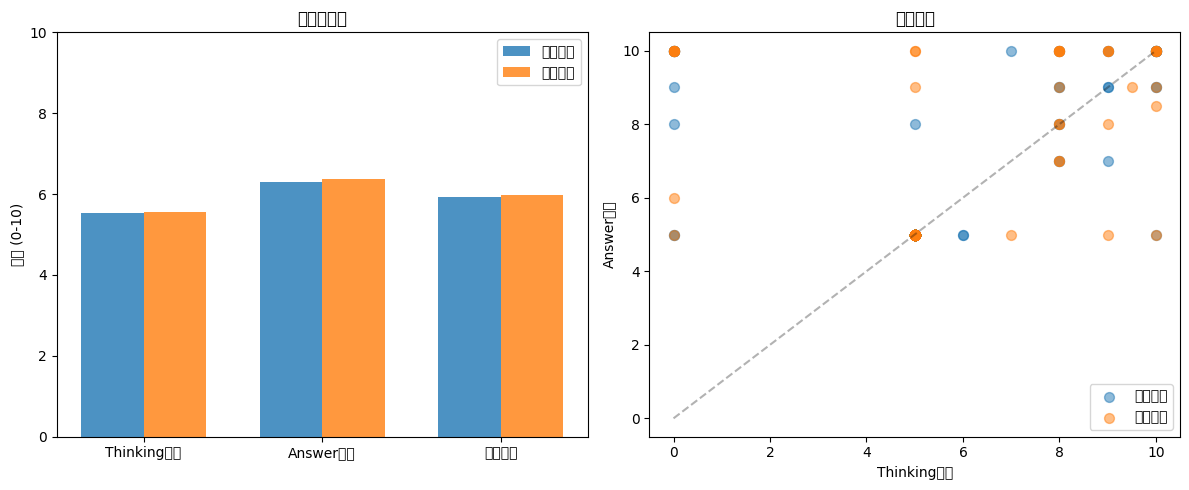


✅ 详细结果已保存: /data/private/evaluation_results.csv

🎉 评测完成！


In [3]:
##llm as judge
#!/usr/bin/env python3
"""
使用Qwen3-235B作为Judge评测微调效果
在Jupyter Notebook中运行
"""

import json
import requests
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# ==================== 配置 ====================
API_URL = "https://aimpapi.midea.com/t-aigc/aimp-qwen3-235b-a22b/v1/chat/completions"
API_KEY = "msk-c3e6e836acff79160513e563d6d288d3e24b9605349a03bb9564e9a7b3bafefe"

BASE_MODEL_FILE = "/data/private/LLaMA-Factory/generated_predictions-qwen3-4b-templateqwen3.jsonl"
TUNED_MODEL_FILE = "/data/private/LLaMA-Factory/generated_predictions-qwen3-4b-lora-newtemplateqwen3.jsonl"

MAX_WORKERS = 10  # 并发数
NUM_SAMPLES = None  # None=全部数据，或设置数字如10

# ==================== 辅助函数 ====================

def extract_think_and_answer(text):
    """提取thinking和answer部分"""
    think_pattern = r'<think>(.*?)</think>'
    match = re.search(think_pattern, text, re.DOTALL)
    
    if match:
        thinking = match.group(1).strip()
        answer = text[match.end():].strip()
        return thinking, answer
    else:
        return "", text.strip()

def call_judge_api(prompt, thinking, answer, ground_truth, eval_type):
    """调用Judge API评分"""
    if eval_type == "thinking":
        user_content = f"""你是一个专业的思维过程评估专家。请评估以下思维过程(thinking)的质量。

评分标准(0-10分):
- 逻辑连贯性(3分): 思维过程是否有清晰的推理链条
- 完整性(3分): 是否涵盖了解决问题的关键步骤
- 深度(2分): 思考是否深入,有无考虑多个角度
- 结构性(2分): 思维组织是否清晰,易于理解

问题: {prompt}

思维过程:
{thinking if thinking else "[无思维过程]"}

标准答案供参考:
{ground_truth[:500]}...

请只输出一个0-10之间的数字分数,不要有其他内容。"""
    else:  # answer
        user_content = f"""你是一个专业的答案质量评估专家。请评估以下答案的质量。

评分标准(0-10分):
- 准确性(4分): 答案是否正确回答了问题
- 完整性(3分): 答案是否全面,有无遗漏关键信息
- 清晰度(2分): 表达是否清晰易懂
- 专业性(1分): 是否使用恰当的专业术语和表达方式

问题: {prompt}

生成的答案:
{answer if answer else "[无答案]"}

标准答案供参考:
{ground_truth[:500]}...

请只输出一个0-10之间的数字分数,不要有其他内容。"""
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    
    payload = {
        "model": "/model/qwen3-235b-a22b",
        "messages": [{"role": "user", "content": user_content}],
        "stream": False,
        "temperature": 0.1
    }
    
    try:
        response = requests.post(API_URL, headers=headers, json=payload, timeout=60)
        if response.status_code == 200:
            result = response.json()
            score_text = result['choices'][0]['message']['content'].strip()
            # 提取数字
            score = float(re.search(r'\d+\.?\d*', score_text).group())
            return min(max(score, 0), 10)
        else:
            print(f"API错误: {response.status_code}")
            return 5.0
    except Exception as e:
        print(f"评分失败: {e}")
        return 5.0

# ==================== 加载数据 ====================

print("📖 加载数据...")
with open(BASE_MODEL_FILE, 'r', encoding='utf-8') as f:
    base_data = [json.loads(line) for line in f]

with open(TUNED_MODEL_FILE, 'r', encoding='utf-8') as f:
    tuned_data = [json.loads(line) for line in f]

if NUM_SAMPLES:
    base_data = base_data[:NUM_SAMPLES]
    tuned_data = tuned_data[:NUM_SAMPLES]

print(f"✅ Base模型: {len(base_data)} 条")
print(f"✅ Tuned模型: {len(tuned_data)} 条")

# 确保数据对应
assert len(base_data) == len(tuned_data), "两个数据集长度不一致！"

# ==================== 分析数据 ====================

print("\n🔍 分析生成结果...")
results = []

for i, (base_item, tuned_item) in enumerate(zip(base_data, tuned_data)):
    # 提取thinking和answer
    base_think, base_ans = extract_think_and_answer(base_item['predict'])
    tuned_think, tuned_ans = extract_think_and_answer(tuned_item['predict'])
    
    results.append({
        'index': i,
        'prompt': base_item['prompt'],
        'label': base_item['label'],
        'base_predict': base_item['predict'],
        'tuned_predict': tuned_item['predict'],
        'base_has_think': bool(base_think),
        'base_think_length': len(base_think),
        'tuned_has_think': bool(tuned_think),
        'tuned_think_length': len(tuned_think),
    })

# 统计基础信息
base_think_rate = sum(r['base_has_think'] for r in results) / len(results) * 100
tuned_think_rate = sum(r['tuned_has_think'] for r in results) / len(results) * 100

print(f"\n📊 基础统计:")
print(f"  Base模型 <think>生成率: {base_think_rate:.1f}%")
print(f"  Tuned模型 <think>生成率: {tuned_think_rate:.1f}%")
print(f"  Base平均thinking长度: {sum(r['base_think_length'] for r in results)/len(results):.0f} 字符")
print(f"  Tuned平均thinking长度: {sum(r['tuned_think_length'] for r in results)/len(results):.0f} 字符")

# ==================== Judge评分 ====================

print(f"\n🎯 开始Judge评分 (并发数={MAX_WORKERS})...")

tasks = []
for i, result in enumerate(results):
    base_think, base_ans = extract_think_and_answer(result['base_predict'])
    tuned_think, tuned_ans = extract_think_and_answer(result['tuned_predict'])
    
    # 4个评分任务
    tasks.extend([
        (i, 'base_think', result['prompt'], base_think, base_ans, result['label'], 'thinking'),
        (i, 'base_answer', result['prompt'], base_think, base_ans, result['label'], 'answer'),
        (i, 'tuned_think', result['prompt'], tuned_think, tuned_ans, result['label'], 'thinking'),
        (i, 'tuned_answer', result['prompt'], tuned_think, tuned_ans, result['label'], 'answer'),
    ])

# 并发评分
scores = {}
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {
        executor.submit(call_judge_api, task[2], task[3], task[4], task[5], task[6]): task
        for task in tasks
    }
    
    for future in tqdm(as_completed(futures), total=len(tasks), desc="评分进度"):
        task = futures[future]
        idx, score_type = task[0], task[1]
        try:
            score = future.result()
            scores[(idx, score_type)] = score
        except Exception as e:
            print(f"任务失败: {e}")
            scores[(idx, score_type)] = 5.0

# 填充评分
for i, result in enumerate(results):
    result['base_think_score'] = scores.get((i, 'base_think'), 5.0)
    result['base_answer_score'] = scores.get((i, 'base_answer'), 5.0)
    result['tuned_think_score'] = scores.get((i, 'tuned_think'), 5.0)
    result['tuned_answer_score'] = scores.get((i, 'tuned_answer'), 5.0)

# ==================== 生成报告 ====================

print("\n" + "="*70)
print("📊 评测结果汇总")
print("="*70)

# 计算平均分
base_think_avg = sum(r['base_think_score'] for r in results) / len(results)
base_answer_avg = sum(r['base_answer_score'] for r in results) / len(results)
tuned_think_avg = sum(r['tuned_think_score'] for r in results) / len(results)
tuned_answer_avg = sum(r['tuned_answer_score'] for r in results) / len(results)

report = {
    "样本数量": len(results),
    "原始模型 (Qwen3-4B)": {
        "Thinking平均分": f"{base_think_avg:.2f}/10",
        "Answer平均分": f"{base_answer_avg:.2f}/10",
        "综合评分": f"{(base_think_avg + base_answer_avg)/2:.2f}/10"
    },
    "微调模型 (Qwen3-4B-LoRA)": {
        "Thinking平均分": f"{tuned_think_avg:.2f}/10",
        "Answer平均分": f"{tuned_answer_avg:.2f}/10",
        "综合评分": f"{(tuned_think_avg + tuned_answer_avg)/2:.2f}/10"
    },
    "提升幅度": {
        "Thinking提升": f"{tuned_think_avg - base_think_avg:+.2f}",
        "Answer提升": f"{tuned_answer_avg - base_answer_avg:+.2f}",
        "综合提升": f"{((tuned_think_avg + tuned_answer_avg) - (base_think_avg + base_answer_avg))/2:+.2f}"
    }
}

print(json.dumps(report, ensure_ascii=False, indent=2))

# ==================== 可视化 ====================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 图1: 平均分对比
categories = ['Thinking质量', 'Answer质量', '综合评分']
base_scores = [base_think_avg, base_answer_avg, (base_think_avg + base_answer_avg)/2]
tuned_scores = [tuned_think_avg, tuned_answer_avg, (tuned_think_avg + tuned_answer_avg)/2]

x = range(len(categories))
width = 0.35

axes[0].bar([i - width/2 for i in x], base_scores, width, label='原始模型', alpha=0.8)
axes[0].bar([i + width/2 for i in x], tuned_scores, width, label='微调模型', alpha=0.8)
axes[0].set_ylabel('评分 (0-10)')
axes[0].set_title('平均分对比')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].set_ylim(0, 10)

# 图2: 分数分布
axes[1].scatter(
    [r['base_think_score'] for r in results],
    [r['base_answer_score'] for r in results],
    alpha=0.5, label='原始模型', s=50
)
axes[1].scatter(
    [r['tuned_think_score'] for r in results],
    [r['tuned_answer_score'] for r in results],
    alpha=0.5, label='微调模型', s=50
)
axes[1].set_xlabel('Thinking评分')
axes[1].set_ylabel('Answer评分')
axes[1].set_title('评分分布')
axes[1].legend()
axes[1].plot([0, 10], [0, 10], 'k--', alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 保存结果 ====================

df = pd.DataFrame(results)
output_file = "/data/private/evaluation_results.csv"
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"\n✅ 详细结果已保存: {output_file}")

print("\n🎉 评测完成！")

In [ ]:

======================================================================
📈 评测结果汇总
======================================================================

📊 总评测样本数: 100

【胜率统计】
  模型A（原始）胜: 21/100 (21.0%)
  模型B（微调）胜: 62/100 (62.0%)
  平局:           17/100 (17.0%)

【各维度平均分对比】(1-5分制)
维度              模型A        模型B        差值        
--------------------------------------------------
正确性             3.60       3.93       +0.33
相关性             3.55       4.03       +0.48
完整性             3.56       3.94       +0.38
推理能力            3.50       3.93       +0.43
表达清晰度           3.31       4.12       +0.81
有用性             3.28       4.12       +0.84

【整体平均分】
  模型A: 3.48
  模型B: 4.28

【结论】: ✅ 微调模型(B)表现明显优于原始模型(A)

======================================================================
🎉 评测完成！
======================================================================

📁 输出文件:
  1. Pairwise数据:    /data/private/outputs/pairwise_comparison_data.jsonl
  2. 详细评测结果:    /data/private/outputs/evaluation_results.jsonl
  3. 汇总报告:        /data/private/outputs/evaluation_summary.json

In [ ]:

python3 tokens.py \
    --input "/data/private/outputs/qwen3_sft_alpaca_format.json" \
    --tokenizer Qwen/Qwen2.5-4B \
    --output token_report_qwen3.json